# DQN CartPole

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T



In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #print(sample_dicts)
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None
        self.action_space_len = action_space_len
        self.fc1 = nn.Linear(state_space_len, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,self.action_space_len-1)
        else:
            #print("greedy")
            return self.forward(obs).argmax().item()
    

In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.as_tensor(np.array(batch.get("state")), dtype=torch.float32)
    action_batch = torch.as_tensor(np.array(batch.get("action")), dtype=torch.int64).unsqueeze(1)
    reward_batch = torch.as_tensor(np.array(batch.get("reward")), dtype=torch.float32).unsqueeze(1)
    next_state_batch = torch.as_tensor(np.array(batch.get("next_state")), dtype=torch.float32)
    done_batch = torch.as_tensor(np.array(batch.get("done")),dtype=torch.int64).unsqueeze(1)

    Q_target_max = target_net.forward(next_state_batch).max(dim=1,keepdim=True)[0]

    target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    Q_policy = policy_net.forward(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.SmoothL1Loss() #Check Loss MSE
    loss = criterion(Q_policy, target_batch)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

episode =  50 mean reward =  23.44
episode =  100 mean reward =  20.19


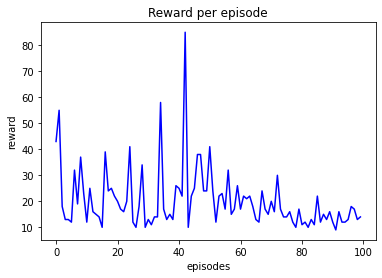

episode =  150 mean reward =  15.25
episode =  200 mean reward =  15.61


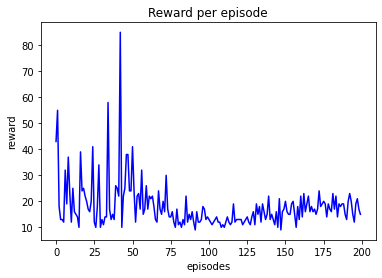

episode =  250 mean reward =  18.69
episode =  300 mean reward =  19.13


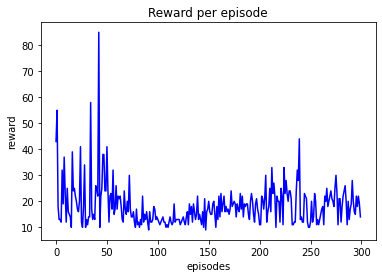

episode =  350 mean reward =  18.57
episode =  400 mean reward =  18.65


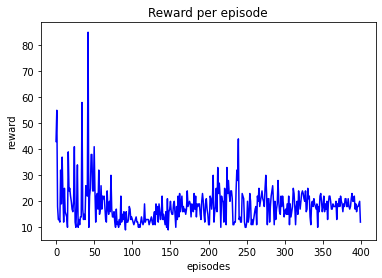

episode =  450 mean reward =  109.6
episode =  500 mean reward =  278.78


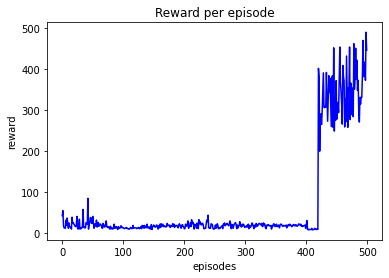

episode =  550 mean reward =  363.81
episode =  600 mean reward =  389.7


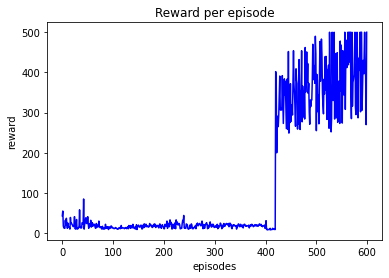

episode =  650 mean reward =  399.13
episode =  700 mean reward =  397.71


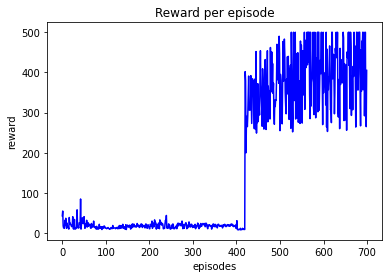

episode =  750 mean reward =  416.7
episode =  800 mean reward =  425.73


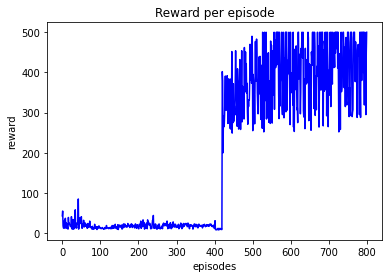

Complete


In [ ]:
BATCH_SIZE = 256 #32 # around 32 for cartpole
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-4#1e-3


TARGET_UPDATE = 400
#max_step = 2000
num_episodes = 800
rewards_per_episode = []


decay_factor = 0.9914#math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)

env = gym.make('CartPole-v1')
memory = ReplayMemory(5000) # <10000

n_actions = env.action_space.n

policy_net = DQN(env.observation_space.shape[0],env.action_space.n)
target_net = DQN(env.observation_space.shape[0],env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())
#target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=learning_rate)


steps_done = 0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    
    for t in count():
        # Select and perform an action    
        action = policy_net.sample_action(torch.as_tensor(state,dtype=torch.float32),epsilon)

        next_state, reward, done, _ = env.step(action)

        if done == True:
          done = 1
        else:
          done = 0
        #reward+= (next_state[0]+ abs(next_state[1]*10))
        #reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
        #print()

        #print(reward)
        curr_episode_reward += reward
        reward = -100*(abs(next_state[2]) - abs(state[2]))

        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state
        
        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    rewards_per_episode.append(curr_episode_reward)
    mean_reward = (np.mean(rewards_per_episode[-100:]))
    #print(i_episode+1)
    if (i_episode+1)% 50 == 0:
      print('episode = ',i_episode+1,'mean reward = ',mean_reward)
    if mean_reward>= 475 and curr_episode_reward>475:
      print("mean_reward> 475")
      break
    if (i_episode+1)%100==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
    # if i_episode+1>40:
    #   average_reward = 0
    #   for i in range(40):
    #     average_reward+=rewards_per_episode[i_episode-i]
      
    #   if (average_reward/40)>=0.51:
    #     break

print('Complete')

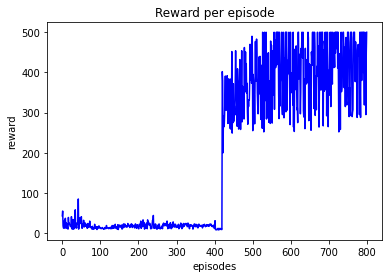

In [ ]:
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
#plt.savefig("Rewards_per_episode_MountainCar.png",dpi = 1200)

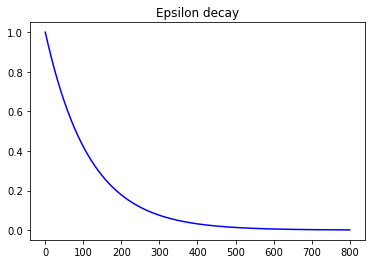

In [ ]:
plt.title("Epsilon decay")
# plt.xlabel('episodes')
# plt.ylabel('reward')
plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Epsilon_decay_MountainCar.png",dpi = 1200)

Complete


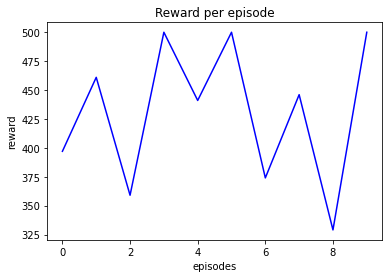

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 10
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in range(1,2000):
        # Select and perform an action    
        action = policy_net.sample_action(torch.as_tensor(state,dtype=torch.float32),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(policy_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)

# DQN Mountain Car

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T



In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #print(sample_dicts)
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None
        self.action_space_len = action_space_len
        self.fc1 = nn.Linear(state_space_len, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,self.action_space_len-1)
        else:
            #print("greedy")
            return self.forward(obs).argmax().item()
    

In [ ]:
a = [{'a':1},{'b':2},{'c':1},{'d':2},{'b':3}]
from collections import defaultdict
dd = defaultdict(list)

for d in a: # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
print(dd)


defaultdict(<class 'list'>, {'a': [1], 'b': [2, 3], 'c': [1], 'd': [2]})


In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.as_tensor(np.array(batch.get("state")), dtype=torch.float32)
    action_batch = torch.as_tensor(np.array(batch.get("action")), dtype=torch.int64).unsqueeze(1)
    reward_batch = torch.as_tensor(np.array(batch.get("reward")), dtype=torch.float32).unsqueeze(1)
    next_state_batch = torch.as_tensor(np.array(batch.get("next_state")), dtype=torch.float32)
    done_batch = torch.as_tensor(np.array(batch.get("done")),dtype=torch.int64).unsqueeze(1)

    Q_target_max = target_net.forward(next_state_batch).max(dim=1,keepdim=True)[0]

    target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    Q_policy = policy_net.forward(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.SmoothL1Loss() #Check Loss MSE
    loss = criterion(Q_policy, target_batch)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

episode =  0 total_reward =  -0.01059666461515809
episode =  50 total_reward =  0.2242787987891377
episode =  100 total_reward =  0.5446825837228136
episode =  150 total_reward =  0.507131891035768
episode =  200 total_reward =  0.34743325699739486
episode =  250 total_reward =  0.6104192547682439
episode =  300 total_reward =  0.5720136388453998
episode =  350 total_reward =  0.5023911019253122
episode =  400 total_reward =  0.5522153800829814
episode =  450 total_reward =  0.5884276205708626


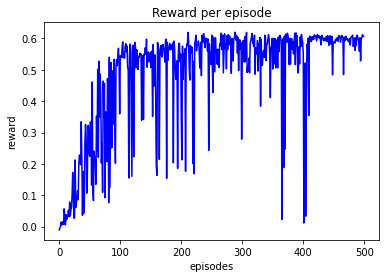

episode =  500 total_reward =  0.5577835315880354
episode =  550 total_reward =  0.6088806825311784
episode =  600 total_reward =  0.5610184251034205
episode =  650 total_reward =  0.533607711839224
episode =  700 total_reward =  0.6021078783089779
episode =  750 total_reward =  0.6101544935435531
Complete


In [ ]:
BATCH_SIZE = 256 #32 # around 32 for cartpole
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-4#1e-3


TARGET_UPDATE = 400
#max_step = 2000
num_episodes = 800
rewards_per_episode = []


decay_factor = 0.9914#math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)

env = gym.make('MountainCar-v0')
memory = ReplayMemory(5000) # <10000

n_actions = env.action_space.n

policy_net = DQN(env.observation_space.shape[0],env.action_space.n)
target_net = DQN(env.observation_space.shape[0],env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())
#target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=learning_rate)


steps_done = 0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    
    for t in count():
        # Select and perform an action    
        action = policy_net.sample_action(torch.as_tensor(state,dtype=torch.float32),epsilon)
        
        next_state, reward, done, _ = env.step(action)
        if done == True:
          done = 1
        else:
          done = 0
        #reward+= (next_state[0]+ abs(next_state[1]*10))
        reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))
        #print()

        #print(reward)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state
        
        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    rewards_per_episode.append(curr_episode_reward)
    if i_episode % 50 == 0:
        print('episode = ',i_episode,'total_reward = ',curr_episode_reward)
    if (i_episode+1)%500==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
    # if i_episode+1>40:
    #   average_reward = 0
    #   for i in range(40):
    #     average_reward+=rewards_per_episode[i_episode-i]
      
    #   if (average_reward/40)>=0.51:
    #     break

print('Complete')

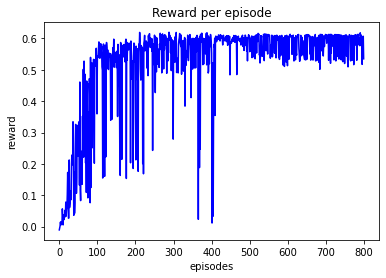

In [ ]:
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
#plt.savefig("Rewards_per_episode_MountainCar.png",dpi = 1200)

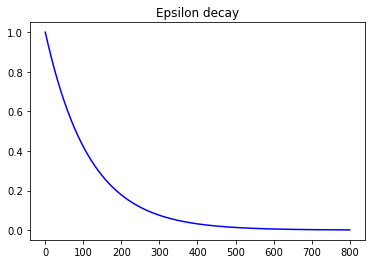

In [ ]:
plt.title("Epsilon decay")
# plt.xlabel('episodes')
# plt.ylabel('reward')
plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Epsilon_decay_MountainCar.png",dpi = 1200)

Complete


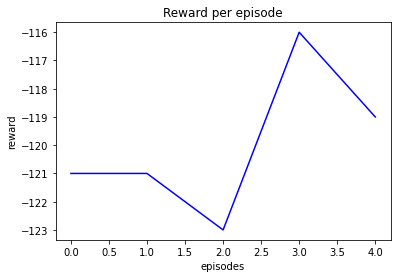

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 5
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in range(1,2000):
        # Select and perform an action    
        action = policy_net.sample_action(torch.as_tensor(state,dtype=torch.float32),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(policy_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)

# DQN Boxing

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces
import pandas as pd


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
a = [[1,2,3,4],1,1,[5,6,7,8]]
b = ["s","a","r","s'"]

dict(zip(b,a))

{'s': [1, 2, 3, 4], 'a': 1, 'r': 1, "s'": [5, 6, 7, 8]}

In [ ]:
!pip install gym[atari,accept-rom-license]==0.21.0

In [ ]:
from itertools import cycle
class ReplayMemory(object):
    #RL Handbook suggests change deque to list
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
from re import X
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(DQN, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          self.action_space_len = action_space_len
          self.actor_conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=6, stride=2,device=device)
          self.actor_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2,device=device)
          # self.actor_conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,device=device)
          self.actor_fc4 = nn.Linear(1568, 128,device=device)
          self.actor_fc5 = nn.Linear(128, action_space_len,device=device)

    def forward(self,x):

      x = F.relu(self.actor_conv1(x))
      #print("1")
      x = F.relu(self.actor_conv2(x))
      #print("2")
      # x = F.relu(self.actor_conv3(x))
      #print("3")
      x = x.view(-1,224*7)
      x = F.relu(self.actor_fc4(x))
      # probs = F.softmax(self.actor_fc5(x),dim = -1)

      return self.actor_fc5(x)

    def sample_action(self, obs, epsilon):
      if random.random() < epsilon:
          return random.randint(0,self.action_space_len-1)
      else:
            #print("greedy")
          return self.forward(obs).argmax().item()

In [ ]:
# a = [{'a':1},{'b':2},{'c':1},{'d':2},{'b':3}]
# from collections import defaultdict
# dd = defaultdict(list)

# for d in a: # you can list as many input dicts as you want here
#     for key, value in d.items():
#         dd[key].append(value)
    
# print(dd)

In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    dd = defaultdict(list)

    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    state_batch = torch.tensor(np.array(batch.get("state")), dtype=torch.float32).to(device)
    #print(state_batch.shape)
    action_batch = torch.as_tensor(np.array(batch.get("action")), dtype=torch.int64).unsqueeze(1).to(device)
    #print(action_batch.shape)
    reward_batch = torch.as_tensor(np.array(batch.get("reward")), dtype=torch.float32).unsqueeze(1).to(device)
    next_state_batch = torch.as_tensor(np.array(batch.get("next_state")), dtype=torch.float32).to(device)
    done_batch = torch.as_tensor(np.array(batch.get("done")),dtype=torch.int64).unsqueeze(1).to(device)

    
    Q_target_max = target_net.forward(next_state_batch).max(dim=1,keepdim=True)[0].to(device)
    target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    Q_policy = policy_net.forward(state_batch).gather(1, action_batch).to(device)
    
    #Calculate Loss
    criterion = nn.MSELoss().to(device) 
    loss = criterion(Q_policy, target_batch).to(device)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

In [ ]:
import cv2
def preprocess_frame(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  frame = frame[8:-12, 4:-12]
  
  frame = cv2.resize(frame, (36, 36))
  return frame

episode =  0 reward =  14.0
episode =  0 mean reward =  14.0
episode =  1 reward =  0.0
episode =  2 reward =  -1.0
episode =  3 reward =  -7.0
episode =  4 reward =  -1.0
episode =  5 reward =  -9.0
episode =  6 reward =  -3.0
episode =  7 reward =  2.0
episode =  8 reward =  11.0
episode =  9 reward =  1.0
episode =  10 reward =  1.0
episode =  10 mean reward =  2.4
episode =  11 reward =  2.0
episode =  12 reward =  -1.0
episode =  13 reward =  1.0
episode =  14 reward =  -5.0
episode =  15 reward =  0.0
episode =  16 reward =  -1.0
episode =  17 reward =  -11.0
episode =  18 reward =  11.0
episode =  19 reward =  3.0


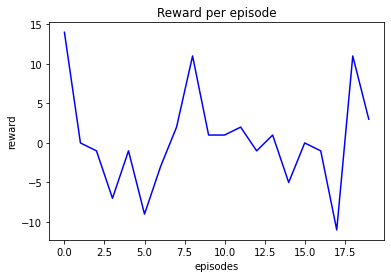

episode =  20 reward =  2.0
episode =  20 mean reward =  0.8
episode =  21 reward =  6.0
episode =  22 reward =  -8.0
episode =  23 reward =  2.0
episode =  24 reward =  3.0
episode =  25 reward =  -2.0
episode =  26 reward =  3.0
episode =  27 reward =  11.0
episode =  28 reward =  -11.0
episode =  29 reward =  -8.0
episode =  30 reward =  0.0
episode =  30 mean reward =  -1.0
episode =  31 reward =  1.0
episode =  32 reward =  0.0
episode =  33 reward =  -6.0
episode =  34 reward =  6.0
episode =  35 reward =  2.0
episode =  36 reward =  5.0
episode =  37 reward =  0.0
episode =  38 reward =  1.0
episode =  39 reward =  -2.0


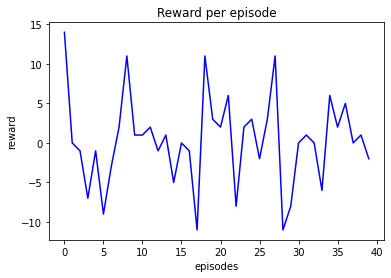

episode =  40 reward =  0.0
episode =  40 mean reward =  0.8
episode =  41 reward =  -3.0
episode =  42 reward =  3.0
episode =  43 reward =  0.0
episode =  44 reward =  -4.0
episode =  45 reward =  4.0
episode =  46 reward =  -2.0
episode =  47 reward =  -2.0
episode =  48 reward =  3.0
episode =  49 reward =  2.0
episode =  50 reward =  -2.0
episode =  50 mean reward =  -0.2
episode =  51 reward =  0.0
episode =  52 reward =  4.0
episode =  53 reward =  0.0
episode =  54 reward =  4.0
episode =  55 reward =  -1.0
episode =  56 reward =  -1.0
episode =  57 reward =  0.0
episode =  58 reward =  2.0
episode =  59 reward =  -5.0


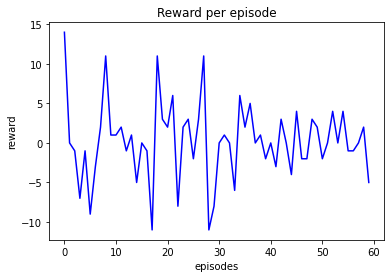

episode =  60 reward =  3.0
episode =  60 mean reward =  -0.2
episode =  61 reward =  5.0
episode =  62 reward =  -19.0
episode =  63 reward =  -7.0
episode =  64 reward =  2.0
episode =  65 reward =  2.0
episode =  66 reward =  -7.0
episode =  67 reward =  -7.0
episode =  68 reward =  1.0
episode =  69 reward =  0.0
episode =  70 reward =  -5.0
episode =  70 mean reward =  -3.6
episode =  71 reward =  3.0
episode =  72 reward =  0.0
episode =  73 reward =  -1.0
episode =  74 reward =  -1.0
episode =  75 reward =  0.0
episode =  76 reward =  1.0
episode =  77 reward =  -12.0
episode =  78 reward =  -4.0
episode =  79 reward =  4.0


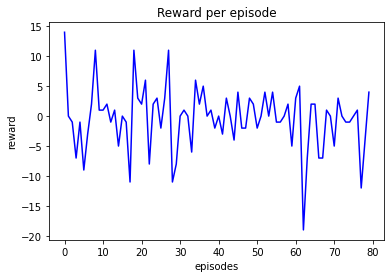

episode =  80 reward =  4.0
episode =  80 mean reward =  -1.4
episode =  81 reward =  -4.0
episode =  82 reward =  -6.0
episode =  83 reward =  6.0
episode =  84 reward =  2.0
episode =  85 reward =  4.0
episode =  86 reward =  5.0
episode =  87 reward =  -3.0
episode =  88 reward =  -2.0
episode =  89 reward =  3.0
episode =  90 reward =  -17.0
episode =  90 mean reward =  -2.8
episode =  91 reward =  -2.0
episode =  92 reward =  -6.0
episode =  93 reward =  8.0
episode =  94 reward =  2.0
episode =  95 reward =  3.0
episode =  96 reward =  2.0
episode =  97 reward =  -12.0
episode =  98 reward =  2.0
episode =  99 reward =  -1.0


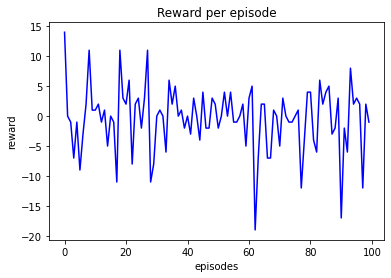

episode =  100 reward =  12.0
episode =  100 mean reward =  0.6
episode =  101 reward =  -3.0
episode =  102 reward =  -4.0
episode =  103 reward =  -10.0
episode =  104 reward =  -10.0
episode =  105 reward =  -7.0
episode =  106 reward =  -1.0
episode =  107 reward =  -2.0
episode =  108 reward =  -1.0
episode =  109 reward =  -5.0
episode =  110 reward =  -8.0
episode =  110 mean reward =  -3.4
episode =  111 reward =  4.0
episode =  112 reward =  -4.0
episode =  113 reward =  6.0
episode =  114 reward =  0.0
episode =  115 reward =  -7.0
episode =  116 reward =  -5.0
episode =  117 reward =  1.0
episode =  118 reward =  0.0
episode =  119 reward =  11.0


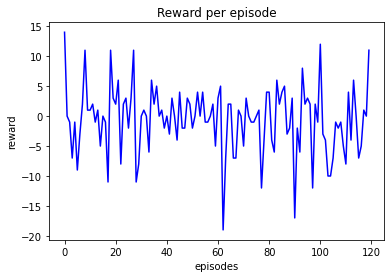

episode =  120 reward =  -3.0
episode =  120 mean reward =  0.8
episode =  121 reward =  -1.0
episode =  122 reward =  -8.0
episode =  123 reward =  -10.0
episode =  124 reward =  -1.0
episode =  125 reward =  6.0
episode =  126 reward =  -3.0
episode =  127 reward =  -2.0
episode =  128 reward =  -7.0
episode =  129 reward =  3.0
episode =  130 reward =  -12.0
episode =  130 mean reward =  -4.2
episode =  131 reward =  -5.0
episode =  132 reward =  -1.0
episode =  133 reward =  -2.0
episode =  134 reward =  -11.0
episode =  135 reward =  0.0
episode =  136 reward =  7.0
episode =  137 reward =  -13.0
episode =  138 reward =  -17.0
episode =  139 reward =  -7.0


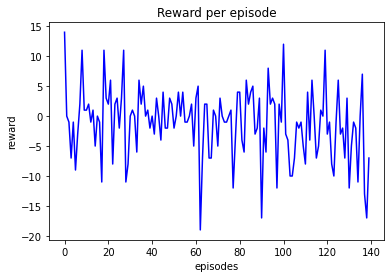

episode =  140 reward =  -11.0
episode =  140 mean reward =  -8.2
episode =  141 reward =  3.0
episode =  142 reward =  -1.0
episode =  143 reward =  -5.0
episode =  144 reward =  -2.0
episode =  145 reward =  0.0
episode =  146 reward =  -1.0
episode =  147 reward =  -16.0
episode =  148 reward =  5.0
episode =  149 reward =  -12.0
Complete


In [ ]:
env = gym.make("Boxing-v4")
env.seed(1234)
BATCH_SIZE = 64 #32 # around 32 for cartpole

GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-3


TARGET_UPDATE = 10
max_step = 1750
num_episodes = 150
rewards_per_episode = []
all_rewards = []


decay_factor = 0.9914#math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)

memory = ReplayMemory(5000) # <10000

n_actions = env.action_space.n

policy_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
#target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=learning_rate)


steps_done = 0
max_episode_reward = 0

for i_episode in range(num_episodes):
    # Initialize the environment and state
    
    rewards = []
    curr_episode_reward = 0
    obs = env.reset(seed=1234)
    obs = preprocess_frame(obs)
    
    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 36, 36)
    
    curr_episode_reward = 0
    
    for t in range(max_step):
        # Select and perform an action
        # display = Display(visible=0, size=(1400, 900))
        # display.start()

        # screen = env.render(mode='rgb_array')

        # plt.imshow(screen)
        # ipythondisplay.clear_output(wait=True)
        # ipythondisplay.display(plt.gcf())  
        curr_state = state
        state = torch.FloatTensor(state).to(device)
        action = policy_net.sample_action(state,epsilon)
        
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state.cpu().numpy()[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 36, 36)
        
        
        # if done == True:
        #   done = 1
        # else:
        #   done = 0
        #reward+= (next_state[0]+ abs(next_state[1]*10))
        curr_episode_reward += reward
        rewards.append(reward)
        reward = np.clip(reward,-1,1)
        #print(done)
        # Store the transition in memory
        memory.push([curr_state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state
        
        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
          all_rewards.append(np.sum(rewards))
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    rewards_per_episode.append(curr_episode_reward)
    print('episode = ',i_episode, "reward = ", curr_episode_reward)
    mean_reward = (np.mean(rewards_per_episode[-5:]))
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % 10 == 0:
        print('episode = ',i_episode, "mean reward = ", mean_reward)#mean_reward)

    if curr_episode_reward > max_episode_reward:
      max_episode_reward = curr_episode_reward
      torch.save(policy_net.state_dict(), "/content/drive/MyDrive/Reinforcement learning/finaldqn/DQN_boxing_final_best_weights.pth")

    if mean_reward>= 20 and curr_episode_reward>=30:
      torch.save(policy_net.state_dict(), "/content/drive/MyDrive/Reinforcement learning/finaldqn/DQN_boxing_final_converged_weights.pth")

      print("mean_reward> threshold")
      break
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # if i_episode>400:
    #     average_reward = 0
    #     for i in range(400):
    #       average_reward+=rewards_per_episode[i_episode-i]
        
    #     if (average_reward/400)>=0.58:
    #       break
    
    if (i_episode+1)%20==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

torch.save(policy_net.state_dict(), "/content/drive/MyDrive/Reinforcement learning/finaldqn/DQN_boxing_final_weights.pth")

print('Complete')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Complete


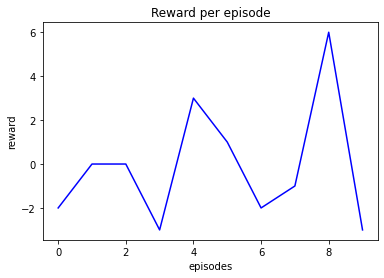

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
policy_net.load_state_dict(torch.load("/content/drive/MyDrive/Reinforcement learning/finaldqn/DQN_boxing_final_best_weights.pth"))

for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    obs = env.reset()
    obs = preprocess_frame(obs)
    
    
    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 36, 36)
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action
        state = torch.FloatTensor(state).to(device)   
        action = policy_net.sample_action(state,epsilon)    
        
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state.cpu().numpy()[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 36, 36)
        curr_episode_reward += reward
        
        # Move to the next state
        state = next_state
        if done:
            break
    
    rewards_per_episode.append(curr_episode_reward)

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()

# Double DQN CartPole

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
%%bash
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None

        self.fc1 = nn.Linear(state_space_len, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,1)
        else:
            return self.forward(obs).argmax().item()
    

In [ ]:
a = [{'a':1},{'b':2},{'c':1},{'d':2},{'b':3}]
from collections import defaultdict
dd = defaultdict(list)

for d in a: # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
    
print(dd)


defaultdict(<class 'list'>, {'a': [1], 'b': [2, 3], 'c': [1], 'd': [2]})


In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.FloatTensor(np.array(batch.get("state"))).to(device)
    action_batch = torch.LongTensor(np.array(batch.get("action"))).unsqueeze(1).to(device)
    reward_batch = torch.FloatTensor(np.array(batch.get("reward"))).unsqueeze(1).to(device)
    next_state_batch = torch.FloatTensor(np.array(batch.get("next_state"))).to(device)
    done_batch = torch.FloatTensor(np.array(batch.get("done"))).unsqueeze(1).to(device)


    #Forward prop target network and calculate target(yi)
    
    Q_primary_max_action_batch = primary_net(next_state_batch).argmax(dim=1).unsqueeze(1).detach()
    #print(Q_primary_max_action_batch.shape)
    Q_optimal = reward_batch + GAMMA *  target_net(next_state_batch).gather(1, Q_primary_max_action_batch).detach() * done_batch

    #Q_target_max = target_net(next_state_batch).max(1)[0].unsqueeze(1).detach()

    #target_batch = reward_batch + GAMMA * Q_target_max * done_batch
    #print(state_batch.shape)
    #print(action_batch.shape)
    Q_primary = primary_net(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.MSELoss() #HuberLoss()#MSELoss() #Check Loss MSE
    loss = criterion(Q_optimal, Q_primary)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    # for param in primary_net.parameters():
    #     param.grad.data.clamp_(-1, 1)

    optimizer.step()

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1


In [ ]:
import gym
from gym import logger as gymlogger
#from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = gym.wrappers.RecordVideo(env, './video')
  return env

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

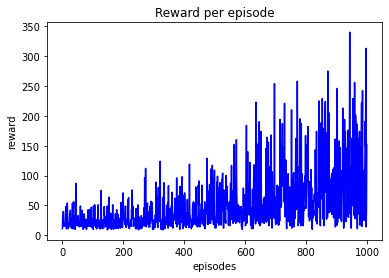

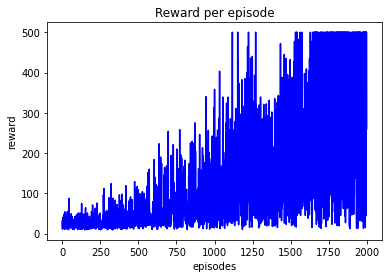

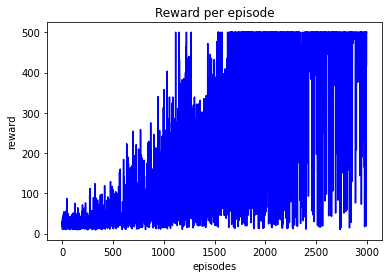

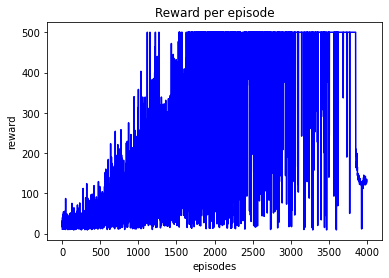

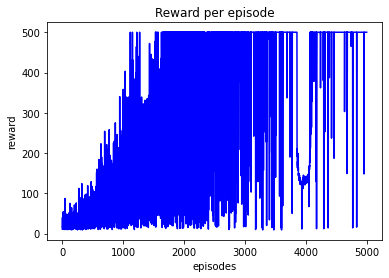

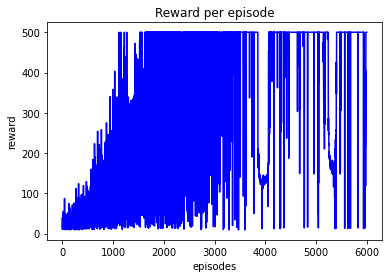

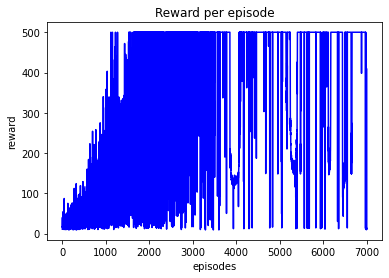

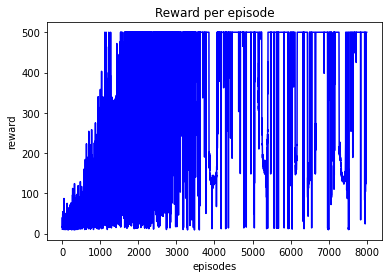

Complete


In [ ]:
BATCH_SIZE = 32 # 64around 32 for cartpole
GAMMA = 0.999
EPS_START = 1
EPS_END = 0.01 # check epsilon value

epsilon = EPS_START
learning_rate = 1e-4


TARGET_UPDATE = 4
max_step = 2000 # 1000
num_episodes = 8000
rewards_per_episode = []

decay_factor = math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)

#env = wrap_env(env)
memory = ReplayMemory(5000) # <10000

n_actions = env.action_space.n

primary_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=learning_rate)


steps_done = 0


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    
    for t in range(max_step):
        # Select and perform an action
        #env.render()
        # screen = env.render(mode='rgb_array')

        # plt.imshow(screen)
        # ipythondisplay.clear_output(wait=True)
        # ipythondisplay.display(plt.gcf())    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon)
        
        next_state, reward, done, _ = env.step(action)
        #reward = np.clip(reward, -1, 1)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          train_step()
        if done:
            break
    
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    if (i_episode+1)%1000==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

print('Complete')
#env.render()
# env.close()
# plt.ioff()
# plt.show()

Complete


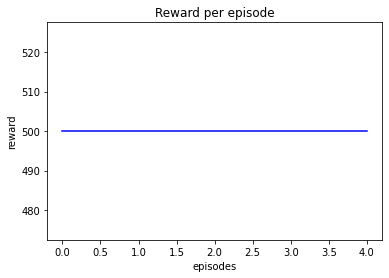

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 5
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in range(1,2000):
        # Select and perform an action    
        action = primary_net.sample_action(torch.from_numpy(state).float().to(device),epsilon) # check
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(primary_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)

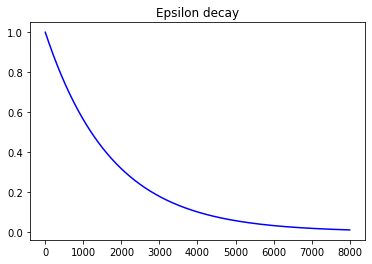

In [ ]:
plt.title("Epsilon decay")

plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Rewards_per_episode_Cartpole.png",dpi = 1200)

# Double DQN MountainCar

In [ ]:
%matplotlib inline

In [ ]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('MountainCar-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [ ]:
from itertools import cycle
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                 action_space_len=None):
        super(DQN, self).__init__()

        assert state_space_len is not None
        assert action_space_len is not None
        self.action_space_len = state_space_len
        self.fc1 = nn.Linear(state_space_len, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_space_len)

    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.fc3(x)

    def sample_action(self, obs, epsilon):
        if random.random() < epsilon:
            return random.randint(0,self.action_space_len-1)
        else:
            return self.forward(obs).argmax().item()
    

In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    #print(batch)
    dd = defaultdict(list)

    # Merge list of dicts into one single dict
    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    #print(batch)
    
    state_batch = torch.as_tensor(np.array(batch.get("state")), dtype=torch.float32)
    action_batch = torch.as_tensor(np.array(batch.get("action")), dtype=torch.int64).unsqueeze(1)
    reward_batch = torch.as_tensor(np.array(batch.get("reward")), dtype=torch.float32).unsqueeze(1)
    next_state_batch = torch.as_tensor(np.array(batch.get("next_state")), dtype=torch.float32)
    done_batch = torch.as_tensor(np.array(batch.get("done")),dtype=torch.int64).unsqueeze(1)


    #Forward prop target network and calculate target(yi)
    Q_primary_max_action_batch = primary_net.forward(next_state_batch).argmax(dim=1,keepdim=True)#.unsqueeze(1)
    Q_optimal = reward_batch + GAMMA *  target_net.forward(next_state_batch).gather(1, Q_primary_max_action_batch)#.detach() * done_batch

    
    Q_primary = primary_net.forward(state_batch).gather(1, action_batch)
    
    #Calculate Loss
    criterion = nn.SmoothL1Loss() #HuberLoss()#MSELoss() #Check Loss MSE
    #print(Q_primary.shape)
    #print(Q_optimal.shape)
    loss = criterion(Q_optimal, Q_primary)

    # Backprop gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

episode =  0 total_reward =  0.0140736886143158
episode =  50 total_reward =  0.0037100828247898874
episode =  100 total_reward =  0.005655912717384382
episode =  150 total_reward =  0.02223408964707861


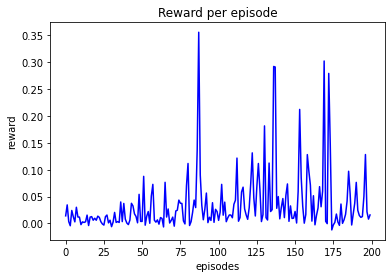

episode =  200 total_reward =  0.0019443961960019362
episode =  250 total_reward =  0.057770910494520517
episode =  300 total_reward =  0.040463222728259716
episode =  350 total_reward =  0.015480531287131439


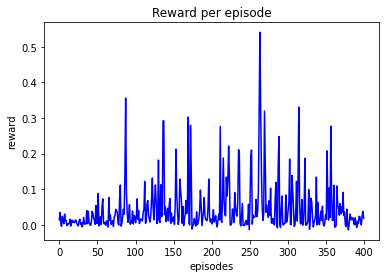

episode =  400 total_reward =  0.010346725610663932
episode =  450 total_reward =  0.003503929789089569
episode =  500 total_reward =  -0.0009758256533158125
episode =  550 total_reward =  0.031459534045907324


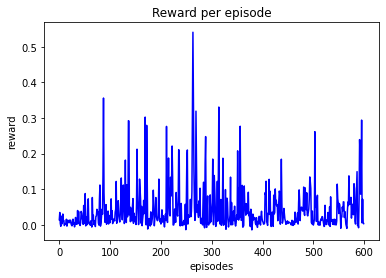

episode =  600 total_reward =  0.0020228818688044926
episode =  650 total_reward =  0.6029406750264301
episode =  700 total_reward =  0.01076907185045242
episode =  750 total_reward =  0.6061306928890945


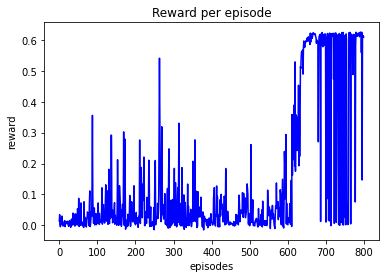

episode =  800 total_reward =  0.6215343167094013
episode =  850 total_reward =  0.4841203520831938
episode =  900 total_reward =  0.40105041584373474
episode =  950 total_reward =  0.6155828172585868


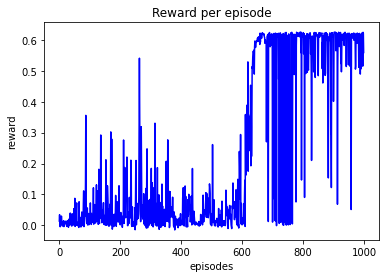

episode =  1000 total_reward =  0.6120626930160215
episode =  1050 total_reward =  0.15975794090640022
episode =  1100 total_reward =  0.6169278028288998
episode =  1150 total_reward =  0.6097986297128822


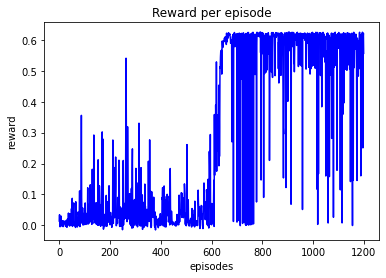

episode =  1200 total_reward =  0.620039041109048
episode =  1250 total_reward =  0.612388920034577
episode =  1300 total_reward =  0.6145155684703033
episode =  1350 total_reward =  0.6229775909156599


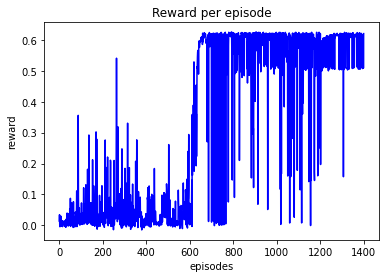

Complete


In [ ]:
BATCH_SIZE = 128 #32 # around 32 for cartpole
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-4#1e-3


TARGET_UPDATE = 600
#max_step = 2000
num_episodes = 1400
rewards_per_episode = []


decay_factor = 0.9914#math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)


memory = ReplayMemory(5000) # <10000

n_actions = env.action_space.n

primary_net = DQN(env.observation_space.shape[0],env.action_space.n)#.to(device)
target_net = DQN(env.observation_space.shape[0],env.action_space.n)#.to(device)
target_net.load_state_dict(primary_net.state_dict())
target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=learning_rate)


steps_done = 0
loss_per_episode = []


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    episode_loss = 0
    t = 0

    for t in count():
        # Select and perform an action    
        action = primary_net.sample_action(torch.as_tensor(state,dtype=torch.float32),epsilon)
        
        next_state, reward, done, _ = env.step(action)

        # reward = 100*((np.sin(3 * next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (np.sin(3 * state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
        # if next_state[0] >= 0.5:
        #     reward += 1
        
        #curr_episode_reward += reward
        
        #reward+= (next_state[0]+ abs(next_state[1]*10))
        reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))

        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          loss = train_step()
          episode_loss+=loss
        if done:
            break
    

    loss_per_episode.append(episode_loss/t)
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    if i_episode % 50 == 0:
        print('episode = ',i_episode,'total_reward = ',curr_episode_reward)
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())

    rewards_per_episode.append(curr_episode_reward)
    if i_episode>400:
        average_reward = 0
        for i in range(400):
          average_reward+=rewards_per_episode[i_episode-i]
        
        if (average_reward/400)>=0.58:
          break
    if (i_episode+1)%200==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

print('Complete')

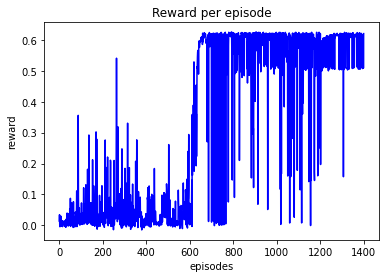

In [ ]:
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
#plt.savefig("Rewards_per_episode_MountainCar.png",dpi = 1200)

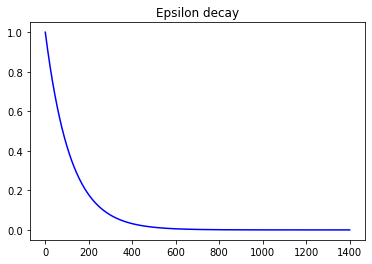

In [ ]:
plt.title("Epsilon decay")
# plt.xlabel('episodes')
# plt.ylabel('reward')
plt.plot(epsilon_per_episode, color="blue")
plt.show()
#plt.savefig("Epsilon_decay_MountainCar.png",dpi = 1200)

Complete


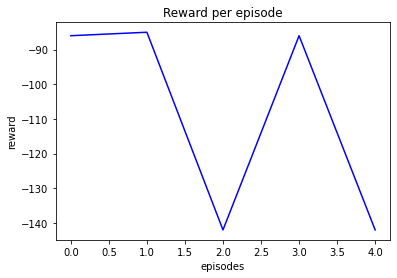

In [ ]:
# plt.title("Epsilon decay")
# # plt.xlabel('episodes')
# # plt.ylabel('reward')
# plt.plot(epsilon_per_episode, color="blue")# Evaluation for 5 episodes
eval_epsiodes = 5
eval_rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        action = primary_net.sample_action(torch.as_tensor(state,dtype=torch.float32),epsilon)
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done, _ = env.step(action)
        #print(terminal_state_reached)
        curr_episode_reward += reward
        #print(done)
        # Store the transition in memory
        #memory.push([state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          pass
          #train_step()
        if done:
            break
    
    # epsilon = epsilon * decay_factor
    # epsilon_per_episode.append(epsilon)
    
    # Update the target network, copying all weights and biases in DQN
    #if i_episode % TARGET_UPDATE == 0:
        #target_net.load_state_dict(policy_net.state_dict())

    eval_rewards_per_episode.append(curr_episode_reward)
    # if (i_episode+1)%100==0:
      # plt.title("Reward per episode")
      # plt.xlabel('episodes')
      # plt.ylabel('reward')
      # plt.plot(rewards_per_episode, color="blue")
      # plt.show()

print('Complete')

plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(eval_rewards_per_episode, color="blue")
plt.show()
#plt.savefig("CartPole_evaluation.png",dpi=1200)

# Double DQN Boxing

In [ ]:
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install gym[atari,accept-rom-license]==0.21.0

In [ ]:
from itertools import cycle
class ReplayMemory(object):
    #RL Handbook suggests change deque to list
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
from re import X
class DQN(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(DQN, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          self.action_space_len = action_space_len
          self.actor_conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=6, stride=2, device=device)
          self.actor_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, device=device)
          #self.actor_conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,device=device)
          self.actor_fc4 = nn.Linear(1568, 128,device=device)
          self.actor_fc5 = nn.Linear(128, action_space_len,device=device)

    def forward(self,x):

      x = F.relu(self.actor_conv1(x))
      #print("1")
      x = F.relu(self.actor_conv2(x))
      #print("2")
      # x = F.relu(self.actor_conv3(x))
      #print("3")
      x = x.view(-1,224*7)
      x = F.relu(self.actor_fc4(x))
      # probs = F.softmax(self.actor_fc5(x),dim = -1)

      return self.actor_fc5(x)

    def sample_action(self, obs, epsilon):
      if random.random() < epsilon:
          return random.randint(0,self.action_space_len-1)
      else:
            #print("greedy")
          return self.forward(obs).argmax().item()

In [ ]:
from collections import defaultdict
def train_step():
    assert len(memory)> BATCH_SIZE, "Check code! Memory length should be greater than Batch size, only then this function is called"

    batch = memory.sample(BATCH_SIZE)
    dd = defaultdict(list)

    for d in batch:
      for key, value in d.items():
          dd[key].append(value)

    batch = dd

    state_batch = torch.as_tensor(np.array(batch.get("state")), dtype=torch.float32).to(device)
    action_batch = torch.as_tensor(np.array(batch.get("action")), dtype=torch.int64).unsqueeze(1).to(device)
    reward_batch = torch.as_tensor(np.array(batch.get("reward")), dtype=torch.float32).unsqueeze(1).to(device)
    next_state_batch = torch.as_tensor(np.array(batch.get("next_state")), dtype=torch.float32).to(device)
    done_batch = torch.as_tensor(np.array(batch.get("done")),dtype=torch.int64).unsqueeze(1).to(device)

    
    #Forward prop target network and calculate target(yi)
    Q_primary_max_action_batch = primary_net.forward(next_state_batch).argmax(dim=1,keepdim=True).to(device)#.unsqueeze(1)
    Q_optimal = reward_batch + GAMMA *  target_net.forward(next_state_batch).gather(1, Q_primary_max_action_batch).to(device)#.detach() * done_batch
    Q_primary = primary_net.forward(state_batch).gather(1, action_batch).to(device)

    
    #Calculate Loss
    criterion = nn.MSELoss().to(device) #HuberLoss()#MSELoss() #Check Loss MSE
    #print(Q_primary.shape)
    #print(Q_optimal.shape)
    loss = criterion(Q_optimal, Q_primary).to(device)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

In [ ]:
import cv2
def preprocess_frame(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  frame = frame[8:-12, 4:-12] # cropping junk pixels

  frame = cv2.resize(frame, (36, 36))
  return frame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


episode =  0 reward =  -1.0
episode =  0 mean reward =  -1.0
episode =  1 reward =  -1.0
episode =  2 reward =  -2.0
episode =  3 reward =  3.0
episode =  4 reward =  3.0
episode =  5 reward =  4.0
episode =  6 reward =  1.0
episode =  7 reward =  5.0
episode =  8 reward =  2.0
episode =  9 reward =  -2.0


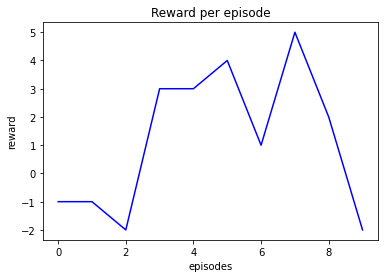

episode =  10 reward =  3.0
episode =  10 mean reward =  1.8
episode =  11 reward =  -4.0
episode =  12 reward =  0.0
episode =  13 reward =  -3.0
episode =  14 reward =  1.0
episode =  15 reward =  5.0
episode =  16 reward =  -4.0
episode =  17 reward =  4.0
episode =  18 reward =  -2.0
episode =  19 reward =  -1.0


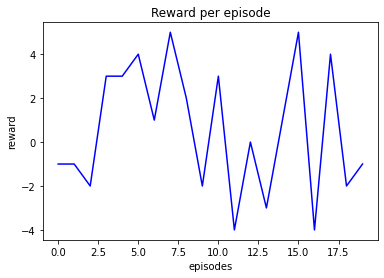

episode =  20 reward =  0.0
episode =  20 mean reward =  -0.6
episode =  21 reward =  -3.0
episode =  22 reward =  0.0
episode =  23 reward =  4.0
episode =  24 reward =  7.0
episode =  25 reward =  -3.0
episode =  26 reward =  -1.0
episode =  27 reward =  -4.0
episode =  28 reward =  1.0
episode =  29 reward =  -7.0


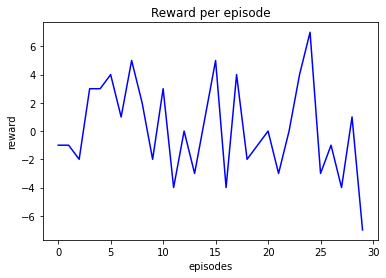

episode =  30 reward =  -6.0
episode =  30 mean reward =  -3.4
episode =  31 reward =  4.0
episode =  32 reward =  3.0
episode =  33 reward =  9.0
episode =  34 reward =  -8.0
episode =  35 reward =  1.0
episode =  36 reward =  0.0
episode =  37 reward =  -1.0
episode =  38 reward =  2.0
episode =  39 reward =  0.0


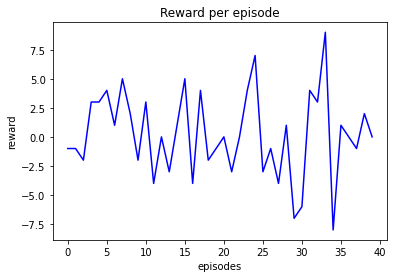

episode =  40 reward =  2.0
episode =  40 mean reward =  0.6
episode =  41 reward =  1.0
episode =  42 reward =  0.0
episode =  43 reward =  2.0
episode =  44 reward =  6.0
episode =  45 reward =  -1.0
episode =  46 reward =  -2.0
episode =  47 reward =  0.0
episode =  48 reward =  3.0
episode =  49 reward =  -3.0


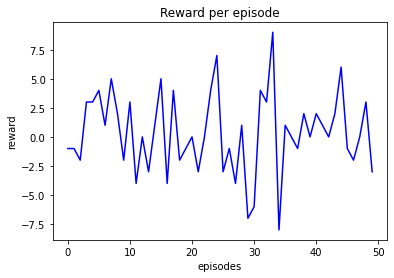

episode =  50 reward =  15.0
episode =  50 mean reward =  2.6
episode =  51 reward =  -4.0
episode =  52 reward =  5.0
episode =  53 reward =  0.0
episode =  54 reward =  -5.0
episode =  55 reward =  -2.0
episode =  56 reward =  4.0
episode =  57 reward =  3.0
episode =  58 reward =  0.0
episode =  59 reward =  4.0


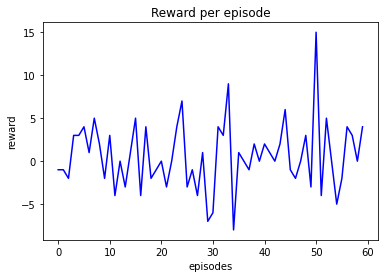

episode =  60 reward =  -1.0
episode =  60 mean reward =  2.0
episode =  61 reward =  5.0
episode =  62 reward =  5.0
episode =  63 reward =  -9.0
episode =  64 reward =  2.0
episode =  65 reward =  -11.0
episode =  66 reward =  -1.0
episode =  67 reward =  -1.0
episode =  68 reward =  2.0
episode =  69 reward =  -2.0


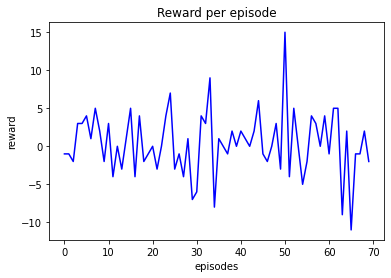

episode =  70 reward =  0.0
episode =  70 mean reward =  -0.4
episode =  71 reward =  -2.0
episode =  72 reward =  -2.0
episode =  73 reward =  -1.0
episode =  74 reward =  10.0
episode =  75 reward =  -1.0
episode =  76 reward =  5.0
episode =  77 reward =  4.0
episode =  78 reward =  8.0
episode =  79 reward =  3.0


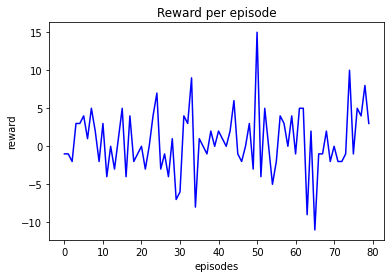

episode =  80 reward =  2.0
episode =  80 mean reward =  4.4
episode =  81 reward =  2.0
episode =  82 reward =  -19.0
episode =  83 reward =  9.0
episode =  84 reward =  6.0
episode =  85 reward =  -6.0
episode =  86 reward =  -3.0
episode =  87 reward =  3.0
episode =  88 reward =  1.0
episode =  89 reward =  -3.0


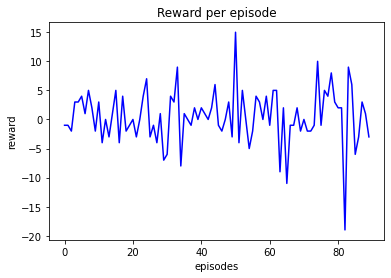

episode =  90 reward =  -2.0
episode =  90 mean reward =  -0.8
episode =  91 reward =  3.0
episode =  92 reward =  -1.0
episode =  93 reward =  0.0
episode =  94 reward =  -1.0
episode =  95 reward =  0.0
episode =  96 reward =  -1.0
episode =  97 reward =  4.0
episode =  98 reward =  -1.0
episode =  99 reward =  0.0


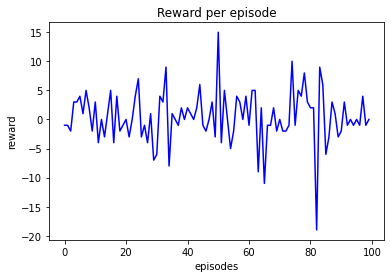

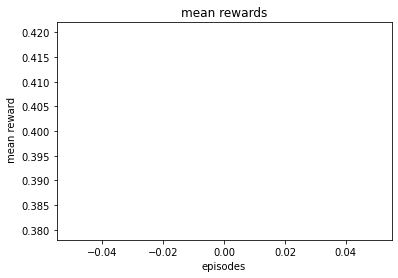

Complete


In [ ]:
env = gym.make("Boxing-v4")
env.seed(1234)

BATCH_SIZE = 1024 #32 # around 32 for cartpole
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01

epsilon = EPS_START
learning_rate = 1e-4 #1e-3


# TARGET_UPDATE = 40
# max_step = 500
# num_episodes = 750
# rewards_per_episode = []

TARGET_UPDATE = 30
#max_steps = 2000
num_episodes = 100
rewards_per_episode = []


decay_factor = 0.9924#math.pow((EPS_END / EPS_START),(1/num_episodes))
epsilon_per_episode = []
epsilon_per_episode.append(epsilon)


memory = ReplayMemory(10000) # <10000

n_actions = env.action_space.n

primary_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0],env.action_space.n).to(device)
target_net.load_state_dict(primary_net.state_dict())
#target_net.eval()

optimizer = optim.Adam(primary_net.parameters(),lr=learning_rate)


steps_done = 0
loss_per_episode = []

max_episode_reward = 0
for i_episode in range(num_episodes):
    # Initialize the environment and state
    curr_episode_reward = 0
    obs = env.reset(seed=1234)
    obs = preprocess_frame(obs)
    
    episode_loss = 0
    t = 0

    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 36, 36)
    curr_episode_reward = 0


    for t in count():
        # Select and perform an action 
        curr_state = state
        state = torch.FloatTensor(state).to(device)   
        action = primary_net.sample_action(state,epsilon)
        
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state.cpu().numpy()[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 36, 36)

        curr_episode_reward += reward
        reward = np.clip(reward,-1,1)
        
        #print(done)
        # Store the transition in memory
        memory.push([curr_state, action,reward,next_state,not done])

        # Move to the next state
        state = next_state

        # Perform one step of optimization (on the policy network)
        if len(memory)>BATCH_SIZE:
          loss = train_step()
          #episode_loss+=loss
        if done:
            break
    

    #loss_per_episode.append(episode_loss/t)
    epsilon = epsilon * decay_factor
    epsilon_per_episode.append(epsilon)
    rewards_per_episode.append(curr_episode_reward)

    mean_reward = (np.mean(rewards_per_episode[-5:]))
        
    print('episode = ',i_episode, "reward = ", curr_episode_reward)#mean_reward)

    if i_episode % 10 == 0:
        print('episode = ',i_episode, "mean reward = ", mean_reward)#mean_reward)

    if curr_episode_reward > max_episode_reward:
      max_episode_reward = curr_episode_reward
      torch.save(primary_net.state_dict(), "/content/drive/MyDrive/Reinforcement learning/final/DDQN_boxing_final_best_weights.pth")

    if mean_reward>= 20 and curr_episode_reward>=30:
      torch.save(primary_net.state_dict(), "/content/drive/MyDrive/Reinforcement learning/final/DDQN_boxing_final_converged_weights.pth")

      print("mean_reward> threshold")
      break
    # Every C steps update the target network with the policy network's weights/params
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(primary_net.state_dict())

    # if i_episode>400:
    #     average_reward = 0
    #     for i in range(400):
    #       average_reward+=rewards_per_episode[i_episode-i]
        
    #     if (average_reward/400)>=0.58:
    #       break
    if (i_episode+1)%10==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()

plt.title("mean rewards")
plt.xlabel('episodes')
plt.ylabel(' mean reward')
plt.plot(mean_reward, color="blue")
plt.show()
torch.save(primary_net.state_dict(), "/content/drive/MyDrive/Reinforcement learning/final/DDQN_boxing_final_weights.pth")

print('Complete')

Complete


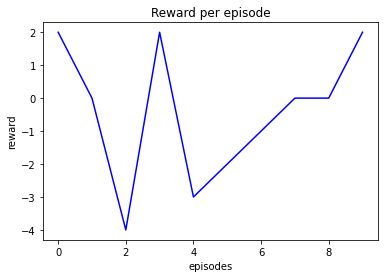

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
primary_net.load_state_dict(torch.load("/content/drive/MyDrive/Reinforcement learning/final/DDQN_boxing_final_best_weights.pth"))
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    obs = env.reset()
    obs = preprocess_frame(obs)
    
    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 36, 36)
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action
        state = torch.FloatTensor(state).to(device)   
        action = primary_net.sample_action(state,epsilon)    
        
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state.cpu().numpy()[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 36, 36)
        curr_episode_reward += reward
        
        # Move to the next state
        state = next_state
        if done:
            break
    
    rewards_per_episode.append(curr_episode_reward)

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()

# A2C CartPole

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from itertools import cycle
class ReplayMemory(object):
    #RL Handbook suggests change deque to list
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, transition: list):
        self.memory.append(transition)

    def sample(self, batch_size):
        sample_list = random.sample(self.memory, batch_size)
        dict_keys = ["state","action","reward","next_state","done"] # Convert to dictionary for ease of use and understanding
        
        sample_dicts = list(map(lambda sample: dict(zip(dict_keys,sample)), sample_list))
        #sample_dict = [zip(sample, dict_keys) for sample in sample list]
        
        return sample_dicts

    def __len__(self):
        return len(self.memory)

In [ ]:
class Actor(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Actor, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          #self.action_space_len = action_space_len
          self.actor_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128,256 ), nn.ReLU(), nn.Linear(256, action_space_len))
      
    def policy(self,x):
      output = self.actor_net(x)
      return F.softmax(output, dim=-1)
    
    
class Critic(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Critic, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None
          
          self.critic_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 1))

          
          
    def v(self,x):
      
      return self.critic_net(x)
    

In [ ]:
from collections import defaultdict

def train_step(log_prob_actions,values,rewards,dones,last_value):
    drewards = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach().to(device)
    
    advantages = drewards - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    

    optimizer_actor.step()
    optimizer_critic.step()



In [ ]:
def calculate_discountedRewards(rewards,V,dones,gamma = 0.99):
    # bootstrapping from last value
    vals = []
    i = len(rewards)-1
    while i!=-1:
      V = rewards[i] + gamma * V * dones[i]
      vals.insert(0,V)
      i-=1
    return vals



In [ ]:
import cv2
def preprocess_frame(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  frame = cv2.resize(frame, (84, 84))
  return frame

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


episode =  0 mean reward =  12.0


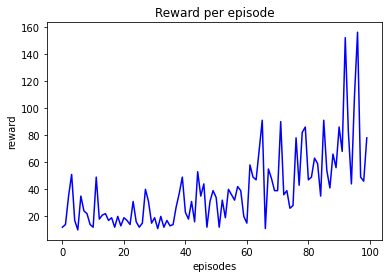

episode =  100 mean reward =  40.19


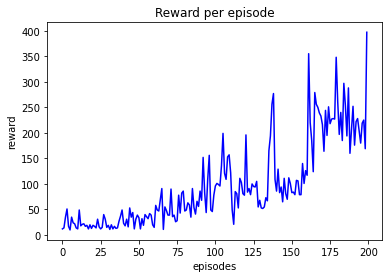

episode =  200 mean reward =  154.3


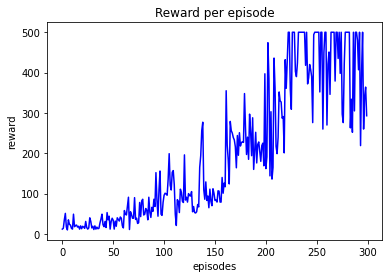

episode =  300 mean reward =  402.81
mean_reward> 475
Complete


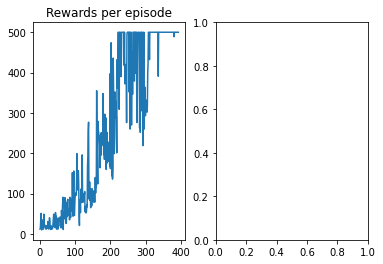

In [ ]:
from torch.distributions import Categorical
#BATCH_SIZE = 64 #200 # around 32 for cartpole
GAMMA = 0.99 #0.999

learning_rate_critic = 1e-3
learning_rate_actor = 1e-3



#max_step = 100 #2000
num_episodes = 5000
rewards_per_episode = []
actor_loss_per_episode = []
crritic_loss_per_episode = []


env = gym.make("CartPole-v1")
#torch.manual_seed(321)
env.seed(1234)
#Discrete
n_actions = env.action_space.n
epsilon_decay_rate = 0.99

actor = Actor(env.observation_space.shape[0],env.action_space.n).to(device)
critic = Critic(env.observation_space.shape[0],env.action_space.n).to(device)


optimizer_actor = optim.Adam(actor.parameters(),lr = learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)
epsilon = 0.99
for i_episode in range(num_episodes):
    # Initialize the environment and state
    log_prob_actions = []
    values = []
    rewards = []
    dones = []
    curr_episode_reward = 0
    state = env.reset()
    env.seed(1234)
    entropy = 0
    # obs = env.reset(seed=1234)
    # obs = preprocess_frame(obs)
    
    
    # state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 84, 84)
    
    curr_episode_reward = 0
   
    for t in count():
        # Select and perform an action    
        prev_state = state.copy()
        state = torch.FloatTensor(state).to(device)
        
        probs = actor.policy(state) # actor
        value = critic.v(state)  #critic

        dist = Categorical(probs)

        # for increasing randomness in mountaincar
        # e_greedy = random.random()
        # if e_greedy > epsilon:
        #     action = dist.sample()
        # else:
        #     action = dist.sample_n(3)
        #     pick = random.randint(0, 2)
        #     action = action[pick]

        action = dist.sample()

        log_prob_action = dist.log_prob(action).unsqueeze(0) #get log probabilities
        
        
        state, reward, done,_ = env.step(action.cpu().numpy())
        #curr_episode_reward += reward

        #reward = 100*((math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]) - (math.sin(3*prev_state[0]) * 0.0025 + 0.5 * prev_state[1] * prev_state[1]))
        # obs, reward, done,_ = env.step(action)
        # obs = preprocess_frame(obs)
        
        # next_state = np.append(state.cpu().numpy()[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 84, 84)

        entropy += dist.entropy().mean()
        epsilon = epsilon * epsilon_decay_rate
        
        # Move to the next state
        #state = next_state

        log_prob_actions.append(log_prob_action)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float).to(device))
        dones.append(torch.tensor([1 - done], dtype=torch.float).to(device))
        curr_episode_reward += reward
        
        if done:
            break
    
    last_value = critic.v(torch.FloatTensor(state).to(device))
    log_prob_actions = torch.cat(log_prob_actions).to(device)
    values = torch.cat(values).to(device)
    #TD_target = torch.cat(calculate_TD(rewards,last_value,dones)).detach()
    TD_target = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach().to(device)
    advantages = TD_target - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean().to(device)# - 0.001 * entropy
    #print(advantages)
    critic_loss = advantages.pow(2).mean().to(device)
    #critic_loss = critic_loss(TD_target,values)
    
    #loss = (actor_loss + 0.5 * critic_loss - 0.001 * entropy).to(device)

    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    #loss.backward()
    actor_loss.backward()
    critic_loss.backward()
    optimizer_actor.step()
    optimizer_critic.step()
    #train_step(log_prob_actions,values,rewards,dones,last_value)

    rewards_per_episode.append(curr_episode_reward)
    
    mean_reward = (np.mean(rewards_per_episode[-100:]))
    if i_episode % 100 == 0:
        
        print('episode = ',i_episode, "mean reward = ", mean_reward)
    
    if mean_reward>= 475 and curr_episode_reward > 475:
      print("mean_reward> 475")
      break

    if (i_episode+1)%100==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
      
      

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

plt.show()

Complete


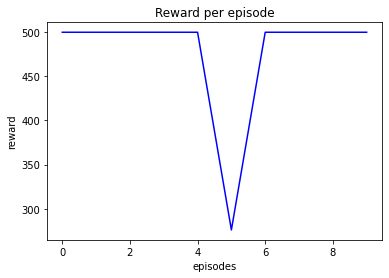

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        probs = actor.policy(torch.from_numpy(state).float().unsqueeze(0))
        action = Categorical(probs).sample().item()#.numpy()
        
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done,_ = env.step(action)
        
        curr_episode_reward += reward

        # Move to the next state
        state = next_state

        if done:
            break 
   
    rewards_per_episode.append(curr_episode_reward)
   

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
#plt.savefig("Gridworld_evaluation.png",dpi=1200)


# A2C Boxing 

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from re import X
class Actor(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Actor, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          self.action_space_len = action_space_len
          self.actor_conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4,device=device)
          self.actor_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2,device=device)
          self.actor_conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,device=device)
          self.actor_fc4 = nn.Linear(1568, 256,device=device)
          self.actor_fc5 = nn.Linear(256, action_space_len,device=device)

    def policy(self,x):

      x = F.relu(self.actor_conv1(x))
      #print("1")
      x = F.relu(self.actor_conv2(x))
      #print("2")
      x = F.relu(self.actor_conv3(x))
      #print("3")
      x = x.view(-1,224*7)
      x = F.relu(self.actor_fc4(x))
      probs = F.softmax(self.actor_fc5(x),dim = -1)

      return probs

    def optimized_combined_fprop(self,x,critic_net):
      x = F.relu(self.actor_conv1(x))
      x = F.relu(self.actor_conv2(x))
      x = F.relu(self.actor_conv3(x))
      x = x.view(-1,224*7)
      actor_fprop = F.relu(self.actor_fc4(x))
      probs = F.softmax(self.actor_fc5(actor_fprop),dim = -1)

      v = F.relu(critic_net.critic_fc1(x))
      v = critic_net.critic_fc2(v)

      return probs, v



class Critic(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Critic, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          self.action_space_len = action_space_len
          self.critic_conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4,device=device)
          self.critic_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2,device=device)
          self.critic_conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,device=device)

          self.critic_fc1  = nn.Linear(1568, 256,device=device)
          self.critic_fc2  = nn.Linear(256, 1,device=device) #Outputs 1 Q value for s,a -> Q(s,a)


    def v(self,x):
      x = F.relu(self.critic_conv1(x))
      
      x = F.relu(self.critic_conv2(x))
      
      x = F.relu(self.critic_conv3(x))
      
      x = x.view(-1,224*7)
      v = F.relu(self.critic_fc1(x))
      v = self.critic_fc2(v)
      return v



In [ ]:
from collections import defaultdict

def train_step(log_prob_actions,values,rewards,dones,last_value):
    drewards = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach().to(device)
    
    advantages = drewards - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    

    optimizer_actor.step()
    optimizer_critic.step()



In [ ]:
def calculate_discountedRewards(rewards,V,dones,gamma = 0.9):
    # bootstrapping from last value
    vals = []
    i = len(rewards)-1
    while i!=-1:
      V = rewards[i] + gamma * V * dones[i]
      vals.insert(0,V)
      i-=1
    return vals



In [ ]:
import cv2
def preprocess_frame(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  frame = cv2.resize(frame, (84, 84))
  return frame

episode =  0 mean reward =  12.0


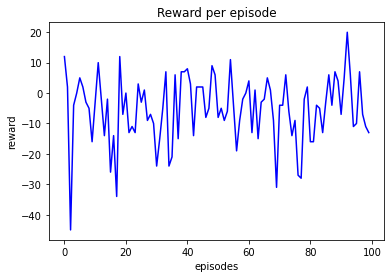

episode =  100 mean reward =  -5.48


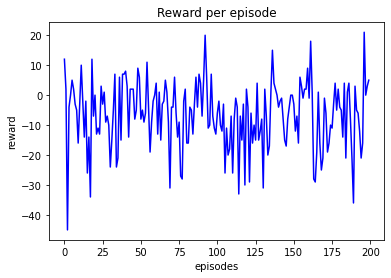

episode =  200 mean reward =  -7.83


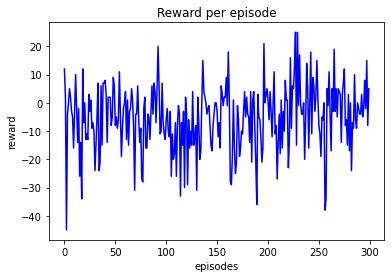

episode =  300 mean reward =  -2.32


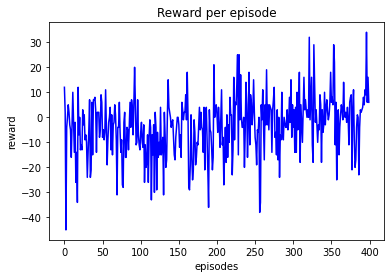

episode =  400 mean reward =  1.69


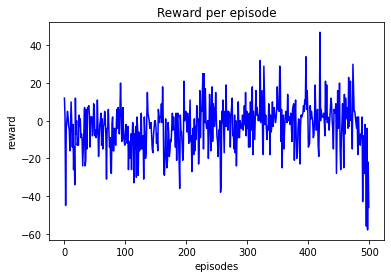

episode =  500 mean reward =  -2.35


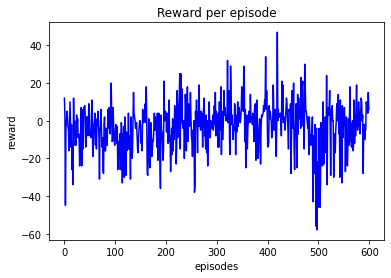

episode =  600 mean reward =  -4.18


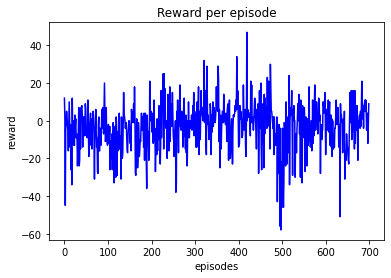

episode =  700 mean reward =  -2.23


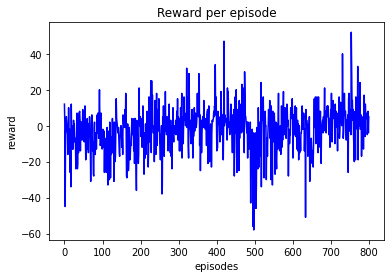

episode =  800 mean reward =  4.48


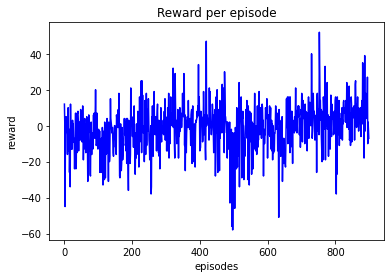

episode =  900 mean reward =  5.51


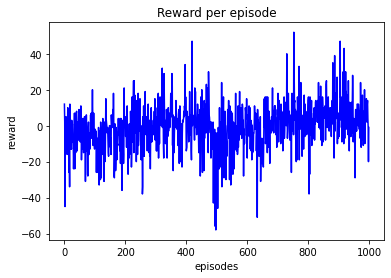

episode =  1000 mean reward =  5.65


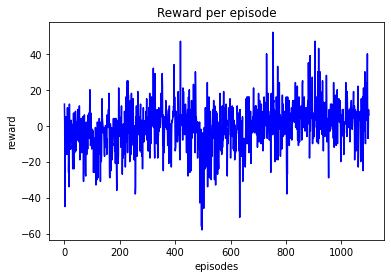

episode =  1100 mean reward =  3.58


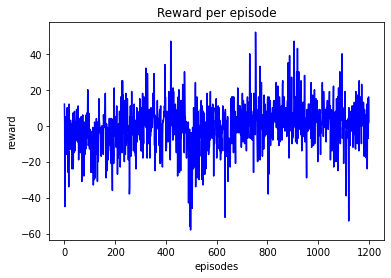

episode =  1200 mean reward =  1.56


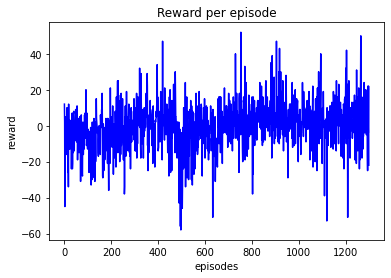

episode =  1300 mean reward =  3.9


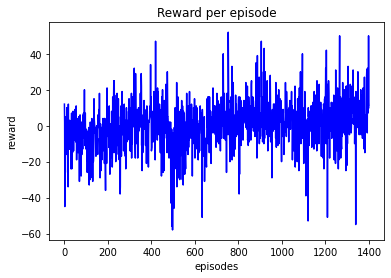

episode =  1400 mean reward =  6.8


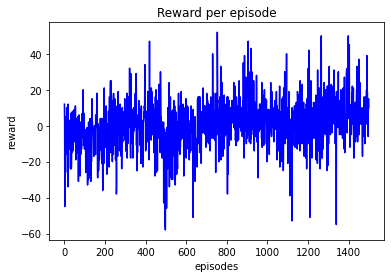

episode =  1500 mean reward =  6.11


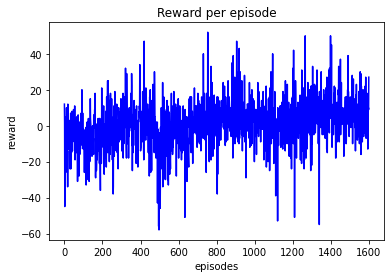

episode =  1600 mean reward =  6.21


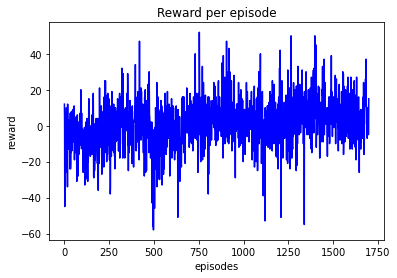

episode =  1700 mean reward =  3.46


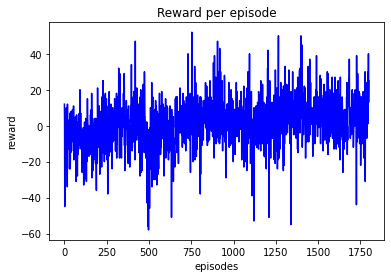

episode =  1800 mean reward =  6.41


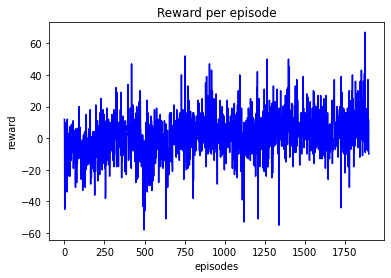

episode =  1900 mean reward =  9.33


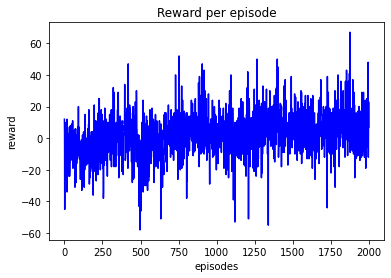

Complete


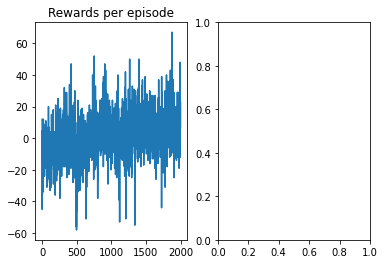

In [ ]:
from torch.distributions import Categorical
#BATCH_SIZE = 64 #200 # around 32 for cartpole
GAMMA = 0.99 #0.999

learning_rate_critic = 1e-4
learning_rate_actor = 1e-4



#max_step = 100 #2000
num_episodes = 2000
rewards_per_episode = []

env = gym.make("Boxing-v4")
#torch.manual_seed(321)
env.seed(1234)
#Discrete
n_actions = env.action_space.n


actor = Actor(env.observation_space.shape[0],env.action_space.n).to(device)
critic = Critic(env.observation_space.shape[0],env.action_space.n).to(device)


optimizer_actor = optim.Adam(actor.parameters(),lr = learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    log_prob_actions = []
    values = []
    rewards = []
    dones = []
    curr_episode_reward = 0
    obs = env.reset(seed=1234)
    obs = preprocess_frame(obs)
    
    
    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 84, 84)
    
    curr_episode_reward = 0
   
   
    for t in count():
        # Select and perform an action    
        
        state = torch.FloatTensor(state).to(device)
        probs ,value= actor.optimized_combined_fprop(state,critic) # actor
        #value = critic.v(state)  #critic

        dist = Categorical(probs)
        action = dist.sample()

        log_prob_action = dist.log_prob(action).unsqueeze(0) #get log probabilities
        
        
        
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state.cpu().numpy()[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 84, 84)

        curr_episode_reward += reward
        reward = np.clip(reward,-1,1)
        
        
        # Move to the next state
        state = next_state

        log_prob_actions.append(log_prob_action)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float).to(device))
        dones.append(torch.tensor([1 - done], dtype=torch.float).to(device))
        curr_episode_reward += reward
        
        if done:
            break
    
    last_value = critic.v(torch.FloatTensor(state).to(device)).to(device)
    log_prob_actions = torch.cat(log_prob_actions).to(device)
    values = torch.cat(values).to(device)
    #TD_target = torch.cat(calculate_TD(rewards,last_value,dones)).detach()
    
    advantages = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach().to(device) - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean().to(device)
    
    critic_loss = advantages.pow(2).mean().to(device)
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward(retain_graph=True)
    critic_loss.backward()
    optimizer_actor.step()
    optimizer_critic.step()
    #train_step(log_prob_actions,values,rewards,dones,last_value)

    rewards_per_episode.append(curr_episode_reward)
    
    mean_reward = (np.mean(rewards_per_episode[-100:]))
    if i_episode % 100 == 0:
        
        print('episode = ',i_episode, "mean reward = ", mean_reward)
    
    if mean_reward>= 100:
      print("mean_reward> 100")
      break

    if (i_episode+1)%100==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
      
      

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

plt.show()

Complete


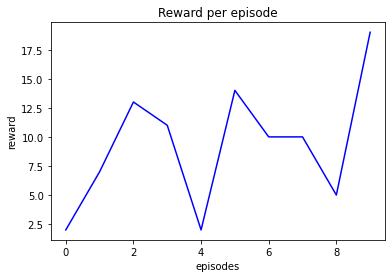

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    obs = env.reset()
    obs = preprocess_frame(obs)
    
    
    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 84, 84)
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        probs = actor.policy(torch.FloatTensor(state).to(device))
        action = Categorical(probs).sample().item()#.numpy()
        
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 84, 84)
        curr_episode_reward += reward
        
        # Move to the next state
        state = next_state
        if done:
            break
    
    rewards_per_episode.append(curr_episode_reward)

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()


# PPO CartPole

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#!pip install gym[atari,accept-rom-license]==0.21.0

In [ ]:
class Actor(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Actor, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          #self.action_space_len = action_space_len
          self.actor_net = nn.Sequential(nn.Linear(state_space_len, 64), nn.ReLU(), nn.Linear(64,128), nn.ReLU(), nn.Linear(128, action_space_len))
      
    def policy(self,x):
      output = self.actor_net(x)
      return F.softmax(output, dim=-1)
    
    
class Critic(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Critic, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None
          
          self.critic_net = nn.Sequential(nn.Linear(state_space_len, 64), nn.ReLU(), nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 1))

          
          
    def v(self,x):
      
      return self.critic_net(x)
    

In [ ]:
from collections import defaultdict

def train_step(log_prob_actions,values,rewards,dones,last_value):
    drewards = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach().to(device)
    
    advantages = drewards - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    

    optimizer_actor.step()
    optimizer_critic.step()



In [ ]:
def calculate_discountedRewards(rewards,V,dones,gamma = 0.99):
    # bootstrapping from last value
    vals = []
    i = len(rewards)-1
    while i!=-1:
      V = rewards[i] + gamma * V * dones[i]
      vals.insert(0,V)
      i-=1
    return vals



In [ ]:
import cv2
def preprocess_frame(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  frame = cv2.resize(frame, (84, 84))
  return frame

episode =  0 mean reward =  19.0


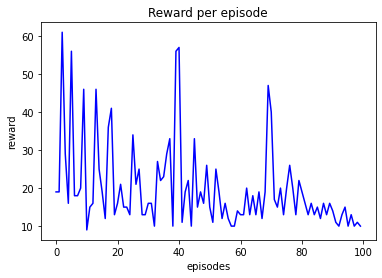

episode =  100 mean reward =  19.87


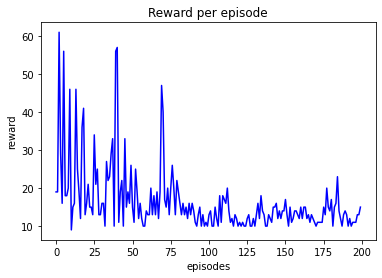

episode =  200 mean reward =  12.95


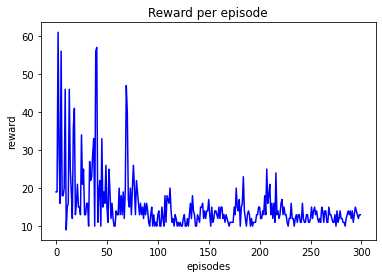

episode =  300 mean reward =  13.17


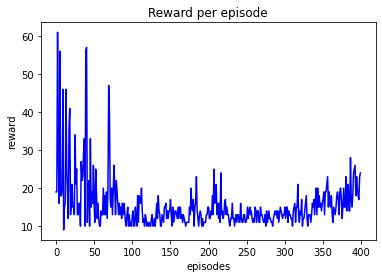

episode =  400 mean reward =  16.2


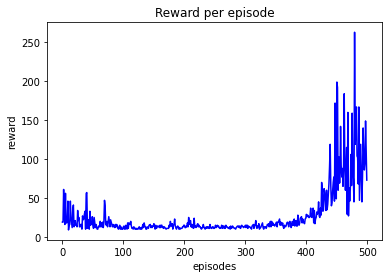

episode =  500 mean reward =  74.14


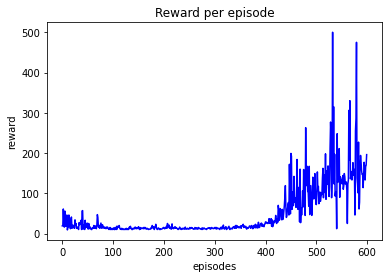

episode =  600 mean reward =  150.78


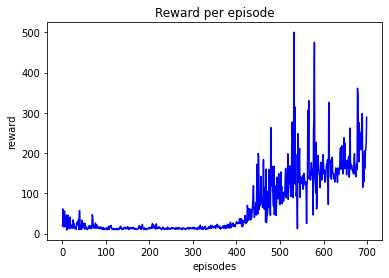

episode =  700 mean reward =  180.0


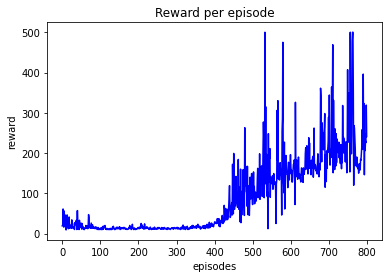

episode =  800 mean reward =  234.57


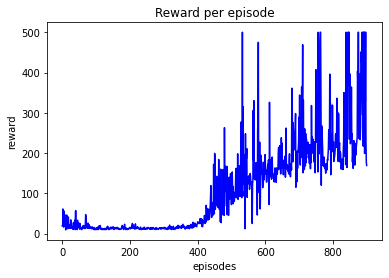

episode =  900 mean reward =  281.22


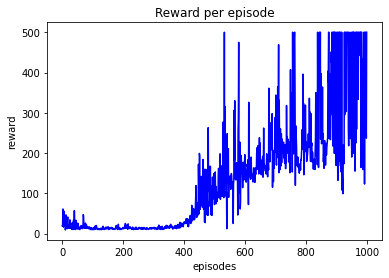

episode =  1000 mean reward =  372.56


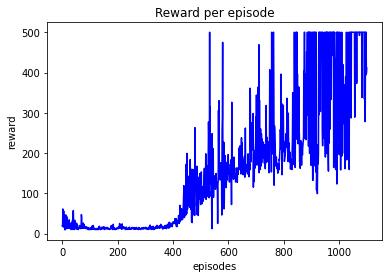

episode =  1100 mean reward =  415.73


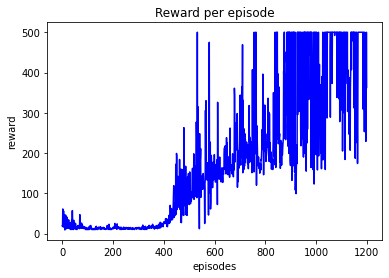

episode =  1200 mean reward =  407.88


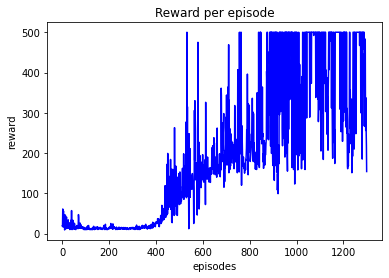

episode =  1300 mean reward =  384.53


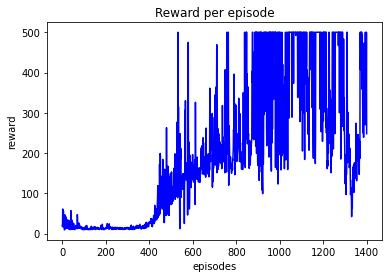

episode =  1400 mean reward =  246.21


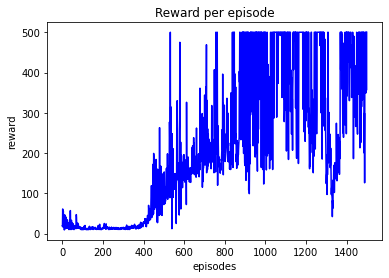

episode =  1500 mean reward =  408.77


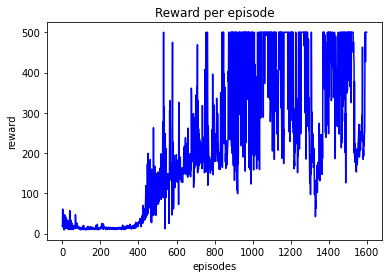

episode =  1600 mean reward =  334.6


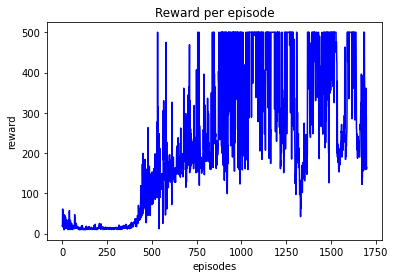

episode =  1700 mean reward =  345.15


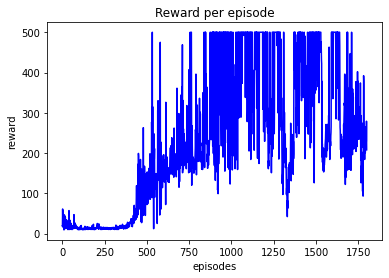

episode =  1800 mean reward =  258.62


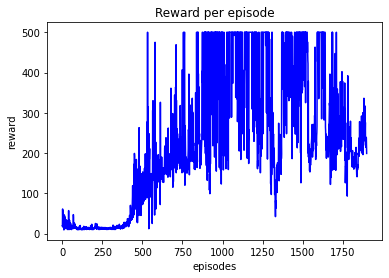

episode =  1900 mean reward =  209.98


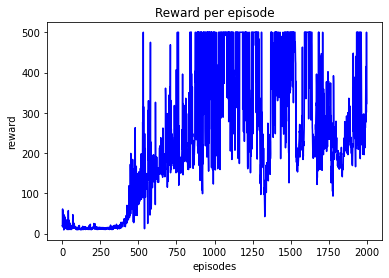

Complete


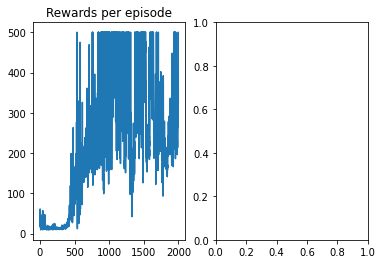

In [ ]:
from torch.distributions import Categorical
#BATCH_SIZE = 64 #200 # around 32 for cartpole
GAMMA = 0.99 #0.999

learning_rate_critic = 5e-4
learning_rate_actor = 5e-4



#max_step = 100 #2000
num_episodes = 2000
rewards_per_episode = []
actor_loss_per_episode = []
crritic_loss_per_episode = []
K = 10  #15    #6              #6  #10
batch_size = 64 #128  #64    #64
env = gym.make("CartPole-v1")
#torch.manual_seed(321)
env.seed(1234)
#Discrete
n_actions = env.action_space.n

epsilon_clip = 0.2 # Clipping epsilon

actor = Actor(env.observation_space.shape[0],env.action_space.n).to(device)
critic = Critic(env.observation_space.shape[0],env.action_space.n).to(device)


optimizer_actor = optim.Adam(actor.parameters(),lr = learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)
epsilon = 0.99
for i_episode in range(num_episodes):
    # Initialize the environment and state
    log_prob_actions_old = []
    actions = []
    states = []
    values = []
    rewards = []
    dones = []
    curr_episode_reward = 0
    state = env.reset(seed=1234)
    #env.seed(1234)
    entropy = 0
    curr_episode_reward = 0
    t=0
    for t in count():
        #print(t)
        # Select and perform an action
        prev_state = state
        state = torch.FloatTensor(state).to(device)
        states.append(state.unsqueeze(0))
        
        probs = actor.policy(state) # actor
        value = critic.v(state)  #critic

        dist = Categorical(probs)

        action = dist.sample()

        log_prob_action = dist.log_prob(action).unsqueeze(0) #get log probabilities
        

        #ratio = torch.exp(log_prob_action - log_probs_old)
        state, reward, done,_ = env.step(action.cpu().numpy())
        curr_episode_reward += reward

        reward = -100*(abs(state[2]) - abs(prev_state[2]))

        entropy += dist.entropy().mean()
        #epsilon = epsilon * epsilon_decay_rate
        #print(action)
        log_prob_actions_old.append(log_prob_action)
        #print("action.shape",action.shape)
        actions.append(torch.tensor([action], dtype=torch.float).to(device).unsqueeze(0))
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float).to(device))
        dones.append(torch.tensor([1 - done], dtype=torch.float).to(device))

        #if t+1 % 20==0:
             


        if done:
            break

    for i in range(K):# Perform K steps of minibatch SGD
      #print(len(states))
      sample_n = batch_size
      if t<batch_size:
        sample_n = t
      #print("minibatch samples: ",sample_n)
      # make minibatch for K SGD steps
      batch_indices = random.sample(range(len(states)),sample_n)
      
      states_batch = torch.cat(states)[batch_indices].detach()
      #print(states_batch.shape)
      #states_batch = states_batch.view(-1,env.observation_space.shape[0]).to(device)
      actions_batch = torch.cat(actions)[batch_indices].detach()
      

      log_prob_actions_old_batch = torch.cat(log_prob_actions_old)[batch_indices].detach()
      values_batch = torch.cat(values)[batch_indices].detach()
      rewards_batch = torch.cat(rewards)[batch_indices].detach()
      dones_batch = torch.cat(dones)[batch_indices].detach()


      new_probs = actor.policy(states_batch).to(device)
      #print(probs.shape)
      new_values = critic.v(states_batch).to(device)

      last_value = critic.v(torch.FloatTensor(state).to(device)).to(device)

      dist = Categorical(new_probs)
      log_prob_actions_batch = dist.log_prob(actions_batch.squeeze(1))#unsqueeze(0)
      
      #print(np.array(log_prob_actions_old,dtype=np.float32).shape)

      #log_prob_actions_old = torch.cat(log_prob_actions_old_batch).to(device)
      #values = torch.cat(values_batch).to(device)
      TD_target = torch.cat(calculate_discountedRewards(rewards_batch,last_value,dones_batch)).to(device)
      #print(log_prob_actions_old.shape)

      advantages = TD_target - values_batch
      #advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

      ratio = torch.exp(log_prob_actions_batch - log_prob_actions_old_batch)

      sloss1 = ratio * advantages
      sloss2 = torch.clamp(ratio.detach(),1-epsilon_clip,1+epsilon_clip) * advantages.detach()
      actor_loss = -torch.min(sloss1, sloss2).mean().to(device)

      critic_loss = 0.5*(TD_target-new_values).pow(2).mean().to(device)
      


      ###Logic below changed
      
      
      # Calculate loss
      
      # Backprop gradients
      optimizer_actor.zero_grad()
      optimizer_critic.zero_grad()
      (actor_loss+critic_loss-0.01*dist.entropy().mean()).backward()#retain_graph=True)#+0.01*entropy).backward()
      nn.utils.clip_grad_norm_(actor.parameters(), 5)
      nn.utils.clip_grad_norm_(critic.parameters(), 5)
      optimizer_actor.step()
      optimizer_critic.step()
      #critic_loss.backward()
      
    #train_step(log_prob_actions,values,rewards,dones,last_value)

    rewards_per_episode.append(curr_episode_reward)
    
    mean_reward = (np.mean(rewards_per_episode[-100:]))
    if i_episode % 100 == 0:
        
        print('episode = ',i_episode, "mean reward = ", mean_reward)
    
    if mean_reward>= 475:
      print("mean_reward> 475")
      break

    if (i_episode+1)%100==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
      
      

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

plt.show()

Complete


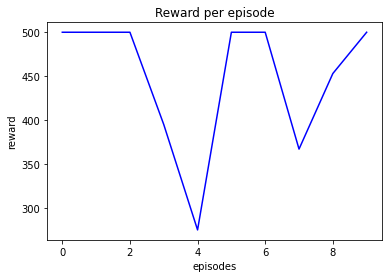

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        probs = actor.policy(torch.FloatTensor(state).to(device)).to(device)
        action = Categorical(probs).sample()
        
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done,_ = env.step(action.cpu().numpy())
        
        curr_episode_reward += reward

        # Move to the next state
        state = next_state

        if done:
            break 
   
    rewards_per_episode.append(curr_episode_reward)
   

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
#plt.savefig("Gridworld_evaluation.png",dpi=1200)


# PPO Boxing

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install gym[atari,accept-rom-license]==0.21.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class Actor(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Actor, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          self.action_space_len = action_space_len
          self.actor_conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4,device=device)
          self.actor_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2,device=device)
          self.actor_conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,device=device)
          self.actor_fc4 = nn.Linear(1568, 256,device=device)
          self.actor_fc5 = nn.Linear(256, action_space_len,device=device)

    def policy(self,x):

      x = F.relu(self.actor_conv1(x))
      x = F.relu(self.actor_conv2(x))
      x = F.relu(self.actor_conv3(x))
      x = x.view(-1,224*7)
      x = F.relu(self.actor_fc4(x))
      probs = F.softmax(self.actor_fc5(x),dim = -1)

      return probs

    def optimized_combined_fprop(self,x,critic_net):
      x = F.relu(self.actor_conv1(x))
      x = F.relu(self.actor_conv2(x))
      x = F.relu(self.actor_conv3(x))
      x = x.view(-1,224*7)
      actor_fprop = F.relu(self.actor_fc4(x))
      probs = F.softmax(self.actor_fc5(actor_fprop),dim = -1)

      v = F.relu(critic_net.critic_fc1(x))
      v = critic_net.critic_fc2(v)

      return probs, v



class Critic(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Critic, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          self.action_space_len = action_space_len
          self.critic_conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4,device=device)
          self.critic_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2,device=device)
          self.critic_conv3 = nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,device=device)

          self.critic_fc1  = nn.Linear(1568, 256,device=device)
          self.critic_fc2  = nn.Linear(256, 1,device=device) #Outputs 1 Q value for s,a -> Q(s,a)


    def v(self,x):
      x = F.relu(self.critic_conv1(x))
      
      x = F.relu(self.critic_conv2(x))
      
      x = F.relu(self.critic_conv3(x))
      
      x = x.view(-1,224*7)
      v = F.relu(self.critic_fc1(x))
      v = self.critic_fc2(v)
      return v



In [ ]:
from collections import defaultdict

def train_step(log_prob_actions,values,rewards,dones,last_value):
    drewards = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach().to(device)
    
    advantages = drewards - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    

    optimizer_actor.step()
    optimizer_critic.step()



In [ ]:
def calculate_discountedRewards(rewards,V,dones,gamma = 0.99):
    # bootstrapping from last value
    vals = []
    i = len(rewards)-1
    while i!=-1:
      V = rewards[i] + gamma * V * dones[i]
      vals.insert(0,V)
      i-=1
    return vals



In [ ]:
import cv2
def preprocess_frame(frame):
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
  frame = cv2.resize(frame, (84, 84))
  return frame

episode =  0 mean reward =  -12.0


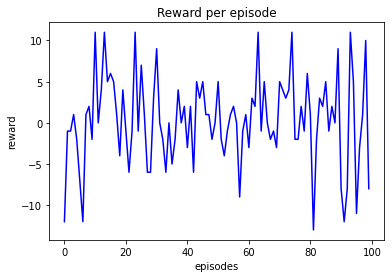

episode =  100 mean reward =  0.46


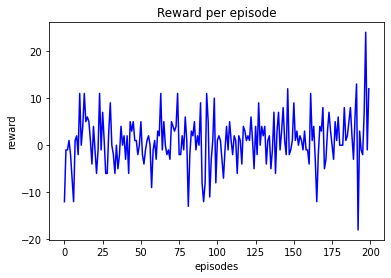

episode =  200 mean reward =  1.46


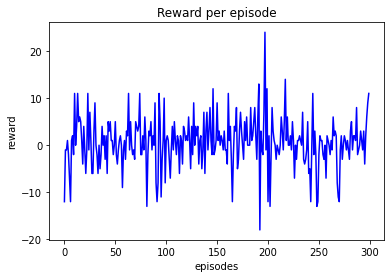

episode =  300 mean reward =  0.1


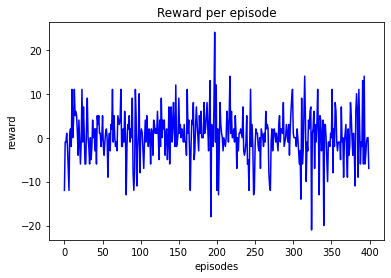

episode =  400 mean reward =  -0.31


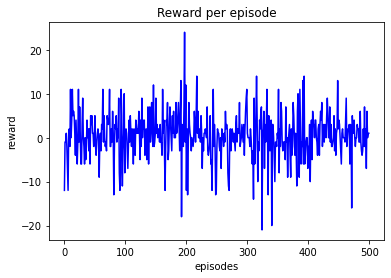

episode =  500 mean reward =  0.93


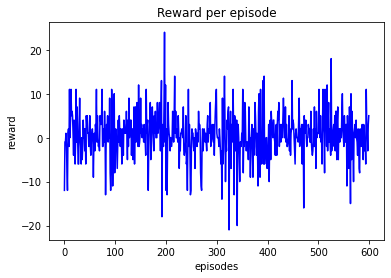

episode =  600 mean reward =  1.03


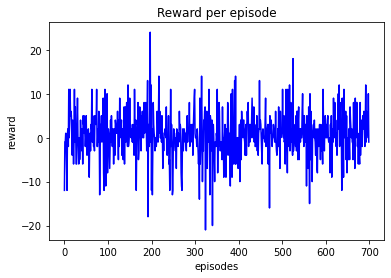

episode =  700 mean reward =  1.26


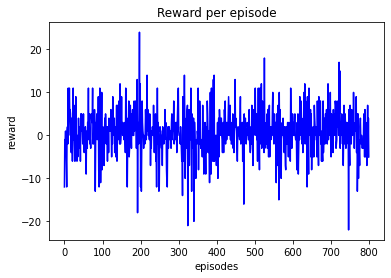

episode =  800 mean reward =  0.72


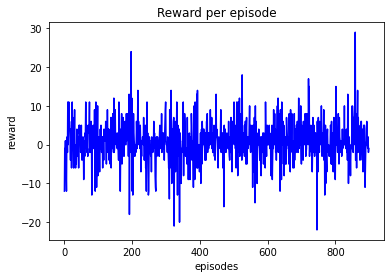

episode =  900 mean reward =  1.42


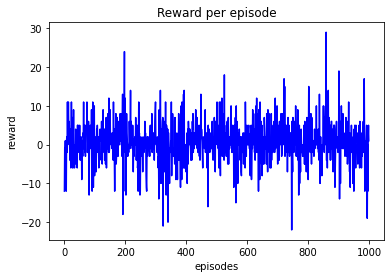

episode =  1000 mean reward =  0.3


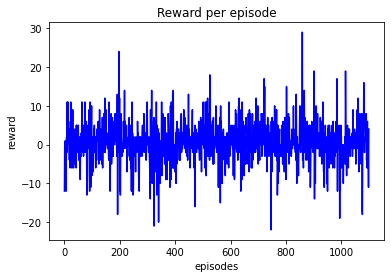

episode =  1100 mean reward =  0.59


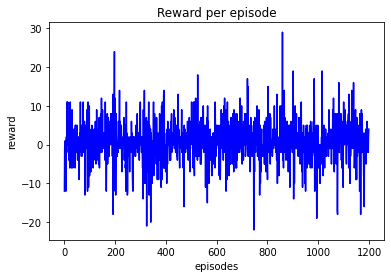

episode =  1200 mean reward =  1.13


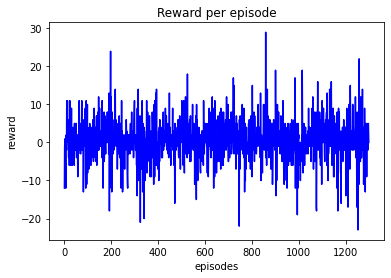

episode =  1300 mean reward =  1.01


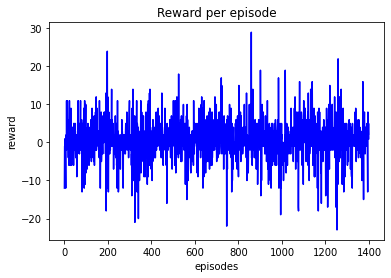

episode =  1400 mean reward =  0.51


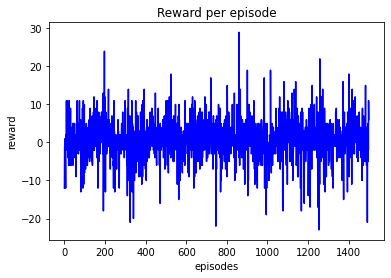

episode =  1500 mean reward =  1.21


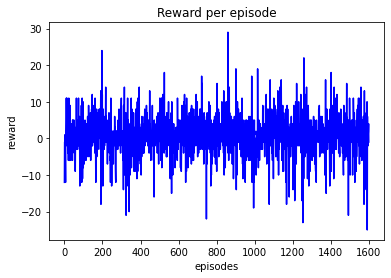

episode =  1600 mean reward =  0.58


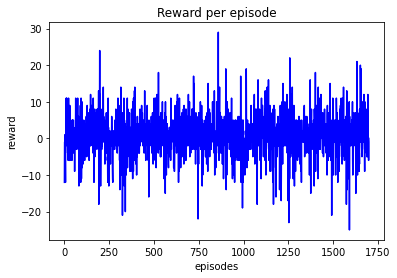

episode =  1700 mean reward =  1.4


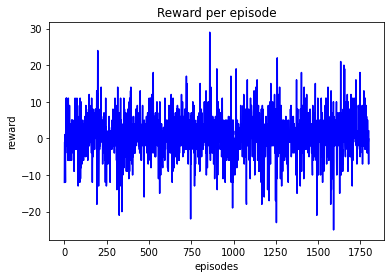

episode =  1800 mean reward =  1.86


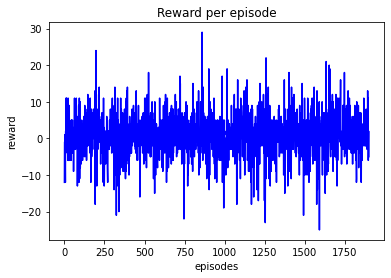

episode =  1900 mean reward =  0.82


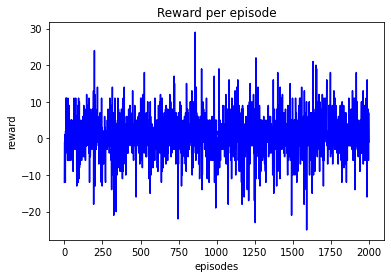

Complete


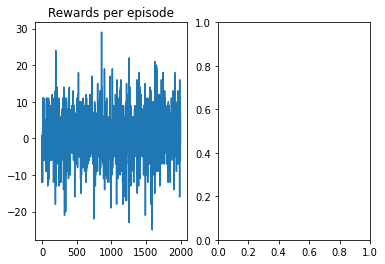

In [ ]:
from torch.distributions import Categorical
#BATCH_SIZE = 64 #200 # around 32 for cartpole
GAMMA = 0.99 #0.999

learning_rate_critic = 1e-3
learning_rate_actor = 2.5e-4



#max_step = 100 #2000
num_episodes = 2000
rewards_per_episode = []
actor_loss_per_episode = []
crritic_loss_per_episode = []
K = 15  #15    #6              #6  #10
batch_size = 128 #128  #64    #64
env = gym.make("Boxing-v4")
#torch.manual_seed(321)
env.seed(1234)
#Discrete
n_actions = env.action_space.n

epsilon_clip = 0.2 # Clipping epsilon

actor = Actor(env.observation_space.shape[0],env.action_space.n).to(device)
critic = Critic(env.observation_space.shape[0],env.action_space.n).to(device)


optimizer_actor = optim.Adam(actor.parameters(),lr = learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)
#epsilon = 0.99
for i_episode in range(num_episodes):
    # Initialize the environment and state
    #if i_episode % 4 == 0:
    log_prob_actions_old = []
    actions = []
    states = []
    values = []
    rewards = []
    dones = []
    curr_episode_reward = 0

    obs = env.reset(seed=1234)
    obs = preprocess_frame(obs)
    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 84, 84)

    for t in count():
        #print(t)
        # Select and perform an action
        prev_state = state
        state = torch.FloatTensor(state).to(device)
        states.append(state.unsqueeze(0))
        
        probs,value = actor.optimized_combined_fprop(state,critic) # actor
        #value = critic.v(state)  #critic

        dist = Categorical(probs)

        action = dist.sample()

        log_prob_action = dist.log_prob(action).unsqueeze(0) #get log probabilities
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state.cpu().numpy()[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 84, 84)
        state = next_state

        curr_episode_reward += reward
        reward = np.clip(reward,-1,1)
        reward+= (-0.01)
        log_prob_actions_old.append(log_prob_action)
      
        actions.append(torch.tensor([action], dtype=torch.float).to(device).unsqueeze(0))
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float).to(device))
        dones.append(torch.tensor([1 - done], dtype=torch.float).to(device))

        if done:
            break

    for i in range(K):# Perform K steps of minibatch SGD
      
      sample_n = batch_size
      if t<batch_size:
        sample_n = t
      
      # make minibatch for K SGD steps
      batch_indices = random.sample(range(len(states)),sample_n)
      
      states_batch = torch.cat(states)[batch_indices].detach()
      actions_batch = torch.cat(actions)[batch_indices].detach()
      log_prob_actions_old_batch = torch.cat(log_prob_actions_old)[batch_indices].detach()
      values_batch = torch.cat(values)[batch_indices].detach()
      rewards_batch = torch.cat(rewards)[batch_indices].detach()
      dones_batch = torch.cat(dones)[batch_indices].detach()


      new_probs,new_values = actor.optimized_combined_fprop(states_batch,critic)#.to(device)
      

      last_value = critic.v(torch.FloatTensor(state).to(device)).to(device)

      dist = Categorical(new_probs.to(device))
      log_prob_actions_batch = dist.log_prob(actions_batch.squeeze(1))#unsqueeze(0)
      
      #print(np.array(log_prob_actions_old,dtype=np.float32).shape)

      #log_prob_actions_old = torch.cat(log_prob_actions_old_batch).to(device)
      #values = torch.cat(values_batch).to(device)
      TD_target = torch.cat(calculate_discountedRewards(rewards_batch,last_value,dones_batch)).to(device)
      #print(log_prob_actions_old.shape)

      advantages = TD_target - values_batch
      #advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

      ratio = torch.exp(log_prob_actions_batch - log_prob_actions_old_batch)

      sloss1 = ratio * advantages
      sloss2 = torch.clamp(ratio.detach(),1-epsilon_clip,1+epsilon_clip) * advantages.detach()
      actor_loss = -torch.min(sloss1, sloss2).mean().to(device)

      critic_loss = 0.5*(TD_target-new_values.to(device)).pow(2).mean().to(device)
      


      ###Logic below changed
      
      
      # Calculate loss
      
      # Backprop gradients
      optimizer_actor.zero_grad()
      optimizer_critic.zero_grad()
      (actor_loss+critic_loss-0.01*dist.entropy().mean()).backward()#retain_graph=True)#+0.01*entropy).backward()
      nn.utils.clip_grad_norm_(actor.parameters(), 5)
      nn.utils.clip_grad_norm_(critic.parameters(), 5)
      optimizer_actor.step()
      optimizer_critic.step()
      #critic_loss.backward()
      
    #train_step(log_prob_actions,values,rewards,dones,last_value)

    rewards_per_episode.append(curr_episode_reward)
    
    mean_reward = (np.mean(rewards_per_episode[-100:]))
    if i_episode % 100 == 0:
        
        print('episode = ',i_episode, "mean reward = ", mean_reward)
    
    # if mean_reward>= 475:
    #   print("mean_reward> 475")
    #   break

    if (i_episode+1)%100==0:
      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
      
      

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

plt.show()

Complete


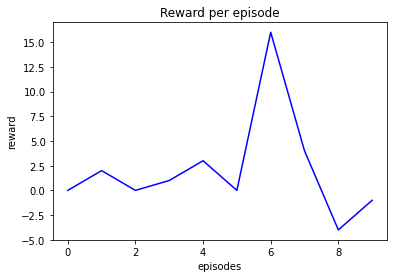

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    obs = env.reset()
    obs = preprocess_frame(obs)
    
    
    state = np.stack([obs, obs, obs, obs], axis=1).reshape(4, 84, 84)
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        probs = actor.policy(torch.FloatTensor(state).to(device))
        action = Categorical(probs).sample().item()#.numpy()
        
        obs, reward, done,_ = env.step(action)
        obs = preprocess_frame(obs)
        
        next_state = np.append(state[1:, :, :], np.expand_dims(obs, axis=0), axis=0).reshape(4, 84, 84)
        curr_episode_reward += reward
        
        # Move to the next state
        state = next_state
        if done:
            break
    
    rewards_per_episode.append(curr_episode_reward)

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
